# 🛠️ Veri Ön İşleme & Feature Engineering
## Uygulamalı Makine Öğrenmesi — Bölüm 2

| | |
|---|---|
| **Önceki Bölüm** | EDA — Keşifsel Veri Analizi |
| **Bu Bölüm** | Veri Temizleme -> Feature Engineering -> Encoding -> Scaling -> Feature Selection -> Model Seçimi |
| **Ders** | Uygulamalı Makine Öğrenmesi |
| **Seviye** | Orta -> İleri |
| **Süre** | ~5 saat |

---

> 📌 **Bu notebook EDA notebookunun devamıdır.**
> Aynı veri setleri kullanılmaktadır (Titanic, Iris, Tips, California Housing).
> Her bölüm bir öncekinin çıktısını girdi olarak alır.

---

## 📋 İçindekiler

1. [Kurulum ve Veri Yükleme](#1)
2. [Veri Temizleme (Data Cleaning)](#2)
3. [Feature Engineering — Yeni Özellik Türetme](#3)
4. [Encoding — Kategorik -> Sayısal](#4)
5. [Scaling — Özellik Ölçeklendirme](#5)
6. [Feature Selection — Özellik Seçimi](#6)
7. [İmbalanced Data — Dengesiz Sınıf Problemi](#7)
8. [Pipeline — Tüm Adımları Birleştirme](#8)
9. [Model Seçimi ve Karşılaştırma](#9)
10. [Hiperparametre Optimizasyonu](#10)
11. [Model Değerlendirme Metrikleri](#11)
12. [Model Yorumlama (SHAP)](#12)
13. [Cross-Validation Stratejileri](#13)
14. [Sonuç ve Production Hazırlığı](#14)

---

## 1. Kurulum ve Veri Yükleme <a id="1"></a>

### 📦 Yeni Kütüphaneler

Bu bölümde EDA'ya ek olarak aşağıdaki kütüphaneleri kullanıyoruz:

| Kütüphane | Kullanım |
|---|---|
| `scikit-learn` | ML algoritmaları, preprocessing, metrikler |
| `imbalanced-learn` | SMOTE ve dengesiz veri teknikleri |
| `shap` | Model yorumlama (SHAP değerleri) |
| `xgboost` | Gradient boosting |
| `lightgbm` | Hızlı gradient boosting |
| `category_encoders` | Gelişmiş encoding yöntemleri |

```bash
pip install scikit-learn imbalanced-learn shap xgboost lightgbm category_encoders
```

In [1]:
# ══════════════════════════════════════════════════════
# BÖLÜM 1: KURULUM VE VERİ YÜKLEME
# ══════════════════════════════════════════════════════

# ── Temel kütüphaneler ────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# ── Scikit-learn: Preprocessing ──────────────────────
from sklearn.preprocessing import (
    StandardScaler,      # Z-score normalizasyon
    MinMaxScaler,        # [0,1] aralığına ölçekleme
    RobustScaler,        # Aykırılara dayanıklı ölçekleme
    LabelEncoder,        # Kategorik -> int (sıralı)
    OneHotEncoder,       # Kategorik -> binary matrix
    OrdinalEncoder,      # Sıralı kategorik encoding
    PowerTransformer,    # Yeo-Johnson / Box-Cox dönüşümü
    QuantileTransformer  # Quantile normalizasyon
)
from sklearn.impute import (
    SimpleImputer,       # Basit eksik veri doldurma
    KNNImputer           # KNN ile eksik doldurma
)

from sklearn.experimental import enable_iterative_imputer  # önce bu
from sklearn.impute import  IterativeImputer     # MICE — çoklu zincirleme

# ── Scikit-learn: Feature Selection ──────────────────
from sklearn.feature_selection import (
    SelectKBest,           # En iyi K özellik
    f_classif,             # ANOVA F-testi (sınıflandırma)
    f_regression,          # F-testi (regresyon)
    mutual_info_classif,   # Mutual Information
    RFE,                   # Recursive Feature Elimination
    RFECV,                 # Cross-validated RFE
    VarianceThreshold,     # Düşük varyanslı özellikleri kaldır
    SelectFromModel        # Model tabanlı seçim
)

# ── Scikit-learn: ML Modelleri ────────────────────────
from sklearn.linear_model import (
    LogisticRegression,
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    RandomForestRegressor,
    GradientBoostingClassifier,
    VotingClassifier,
    BaggingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# ── Scikit-learn: Değerlendirme ───────────────────────
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix,
    classification_report, ConfusionMatrixDisplay,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# ── XGBoost & LightGBM ───────────────────────────────
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
except ImportError:
    XGB_AVAILABLE = False
    print("⚠️  xgboost kurulu degil: pip install xgboost")

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
except ImportError:
    LGB_AVAILABLE = False
    print("⚠️  lightgbm kurulu degil: pip install lightgbm")

# ── SHAP ─────────────────────────────────────────────
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️  shap kurulu degil: pip install shap")

# ── Imbalanced-learn ─────────────────────────────────
try:
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBLEARN_AVAILABLE = True
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("⚠️  imbalanced-learn kurulu degil: pip install imbalanced-learn")

# ── Görsel ayarlar ────────────────────────────────────
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (12, 7),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
})
import plotly.io as pio
pio.templates.default = "plotly_white"

print("Tum kutuphaneler yuklendi!")
print("-" * 45)
print(f"  scikit-learn : {__import__('sklearn').__version__}")
print(f"  pandas       : {pd.__version__}")
print(f"  numpy        : {np.__version__}")
if XGB_AVAILABLE:  print(f"  xgboost      : {xgb.__version__}")
if LGB_AVAILABLE:  print(f"  lightgbm     : {lgb.__version__}")
print("-" * 45)

Tum kutuphaneler yuklendi!
---------------------------------------------
  scikit-learn : 1.6.1
  pandas       : 2.2.2
  numpy        : 2.0.2
  xgboost      : 3.2.0
  lightgbm     : 4.6.0
---------------------------------------------


In [2]:
# ── Veri setlerini yükle ─────────────────────────────────
from sklearn.datasets import fetch_california_housing

def veri_yukle():
    datasets = {}
    titanic = sns.load_dataset('titanic')
    datasets['titanic'] = titanic
    iris = sns.load_dataset('iris')
    datasets['iris'] = iris
    tips = sns.load_dataset('tips')
    datasets['tips'] = tips
    housing_raw = fetch_california_housing(as_frame=True)
    datasets['housing'] = housing_raw.frame
    print("Tum veri setleri yuklendi!")
    for k, v in datasets.items():
        print(f"  {k:10s}: {v.shape[0]:6,} x {v.shape[1]} sutun")
    return datasets

veri = veri_yukle()
df_raw    = veri['titanic'].copy()   # Ham veri — hic dokunmayacagiz
df        = veri['titanic'].copy()   # Isleme yapacagimiz kopya
iris      = veri['iris'].copy()
tips      = veri['tips'].copy()
housing   = veri['housing'].copy()

print(f"\nAna veri seti: Titanic ({df.shape[0]} x {df.shape[1]})")

Tum veri setleri yuklendi!
  titanic   :    891 x 15 sutun
  iris      :    150 x 5 sutun
  tips      :    244 x 7 sutun
  housing   : 20,640 x 9 sutun

Ana veri seti: Titanic (891 x 15)


## 2. Veri Temizleme (Data Cleaning) <a id="2"></a>

Veri temizleme, ham verinin analiz ve modellemeye hazır hale getirilmesi sürecidir.

### 🗂️ Temizleme Adımları

```
Ham Veri
   │
   ├── 1. Tekrarlı satırları kaldır
   ├── 2. Alakasız/yararsız sütunları kaldır
   ├── 3. Veri tiplerini düzelt
   ├── 4. Eksik veri doldur
   ├── 5. Aykırı değerleri işle
   └── 6. Tutarsız değerleri düzelt
         │
      Temiz Veri
```

### ⚠️ Altın Kural
> Ham veriyi **asla üzerine yazmayın**. Her zaman `.copy()` ile çalışın,
> orijinal veriye geri dönebilmek için saklayın.

In [3]:
# ══════════════════════════════════════════════════════
# BÖLÜM 2: VERİ TEMİZLEME
# ══════════════════════════════════════════════════════

print("=" * 55)
print("  ADIM 1: Ham Veri Durumu")
print("=" * 55)
print(f"  Boyut           : {df.shape}")
print(f"  Toplam eksik    : {df.isnull().sum().sum()}")
print(f"  Tekrarli satir  : {df.duplicated().sum()}")
print(f"  Sutunlar        : {df.columns.tolist()}")

  ADIM 1: Ham Veri Durumu
  Boyut           : (891, 15)
  Toplam eksik    : 869
  Tekrarli satir  : 107
  Sutunlar        : ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']


In [4]:
# ── Adım 1: Tekrarlı satırları kaldır ───────────────────────
# .duplicated() -> hangi satırlar birebir aynı?
# keep='first' -> ilk görülen kalır, tekrarlar silinir

tekrar_sayisi = df.duplicated().sum()
print(f"Tekrarli satir sayisi: {tekrar_sayisi}")

if tekrar_sayisi > 0:
    df = df.drop_duplicates(keep='first').reset_index(drop=True)
    print(f"Silindi. Yeni boyut: {df.shape}")
else:
    print("Tekrarli satir yok.")

# ── Adım 2: Alakasız sütunları kaldır ───────────────────────
# 'alive', 'who', 'adult_male' gibi sütunlar 'survived' ve 'sex'
# değişkenlerinin türevi — bilgi sızıntısı (data leakage) yaratır!
# 'embark_town' ile 'embarked' aynı bilgiyi taşıyor -> birini kaldır

gereksiz = ['alive', 'who', 'adult_male', 'embark_town', 'class', 'deck']
mevcut_gereksiz = [c for c in gereksiz if c in df.columns]

print(f"\nKaldirilacak sutunlar: {mevcut_gereksiz}")
df = df.drop(columns=mevcut_gereksiz)
print(f"Temizlendi. Kalan sutunlar: {df.columns.tolist()}")

Tekrarli satir sayisi: 107
Silindi. Yeni boyut: (784, 15)

Kaldirilacak sutunlar: ['alive', 'who', 'adult_male', 'embark_town', 'class', 'deck']
Temizlendi. Kalan sutunlar: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'alone']


In [5]:
# ── Adım 3: Veri tiplerini düzelt ───────────────────────────
print("Veri tipleri (duzeltme oncesi):")
print(df.dtypes)
print()

# 'survived' ve 'pclass' integer olmalı
# Seaborn bazen bunları float yükler
df['survived'] = df['survived'].astype(int)
df['pclass']   = df['pclass'].astype(int)

# Kategorik sütunları açıkça category tipine çevir
# Bu hem bellek tasarrufu hem de later encoding için faydalıdır
kategorik_sutunlar = ['sex', 'embarked']
for col in kategorik_sutunlar:
    if col in df.columns:
        df[col] = df[col].astype('category')

print("Veri tipleri (duzeltme sonrasi):")
print(df.dtypes)
print(f"\nBellek: {df.memory_usage(deep=True).sum()/1024:.1f} KB")

Veri tipleri (duzeltme oncesi):
survived      int64
pclass        int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
alone          bool
dtype: object

Veri tipleri (duzeltme sonrasi):
survived       int64
pclass         int64
sex         category
age          float64
sibsp          int64
parch          int64
fare         float64
embarked    category
alone           bool
dtype: object

Bellek: 39.6 KB


In [6]:
# ── Adım 4: Eksik Veri Doldurma ────────────────────────────
# Strateji Titanic veri setine özel:
#   'age'      -> %20 eksik -> medyan imputation
#   'embarked' -> 2 eksik   -> mod imputation
#   'fare'     -> 1 eksik   -> medyan imputation

print("Eksik veri ozeti (doldurma oncesi):")
eksik = df.isnull().sum()
print(eksik[eksik > 0])

# ── 4a. Sayısal: Medyan ile doldur ──────────────────────
# Medyan, aykırı değerlere karşı dirençlidir
if 'age' in df.columns:
    medyan_yas = df['age'].median()
    df['age']  = df['age'].fillna(medyan_yas)
    print(f"\n'age' medyan ({medyan_yas:.1f}) ile dolduruldu.")

if 'fare' in df.columns:
    medyan_ucret = df['fare'].median()
    df['fare']   = df['fare'].fillna(medyan_ucret)
    print(f"'fare' medyan ({medyan_ucret:.2f}) ile dolduruldu.")

# ── 4b. Kategorik: Mod ile doldur ───────────────────────
if 'embarked' in df.columns:
    mod_liman    = df['embarked'].mode()[0]
    df['embarked'] = df['embarked'].fillna(mod_liman)
    print(f"'embarked' mod ('{mod_liman}') ile dolduruldu.")

print(f"\nToplam eksik (doldurma sonrasi): {df.isnull().sum().sum()}")

Eksik veri ozeti (doldurma oncesi):
age         106
embarked      2
dtype: int64

'age' medyan (28.2) ile dolduruldu.
'fare' medyan (15.90) ile dolduruldu.
'embarked' mod ('S') ile dolduruldu.

Toplam eksik (doldurma sonrasi): 0


'fare' winsorized: max 512.33 -> 262.38


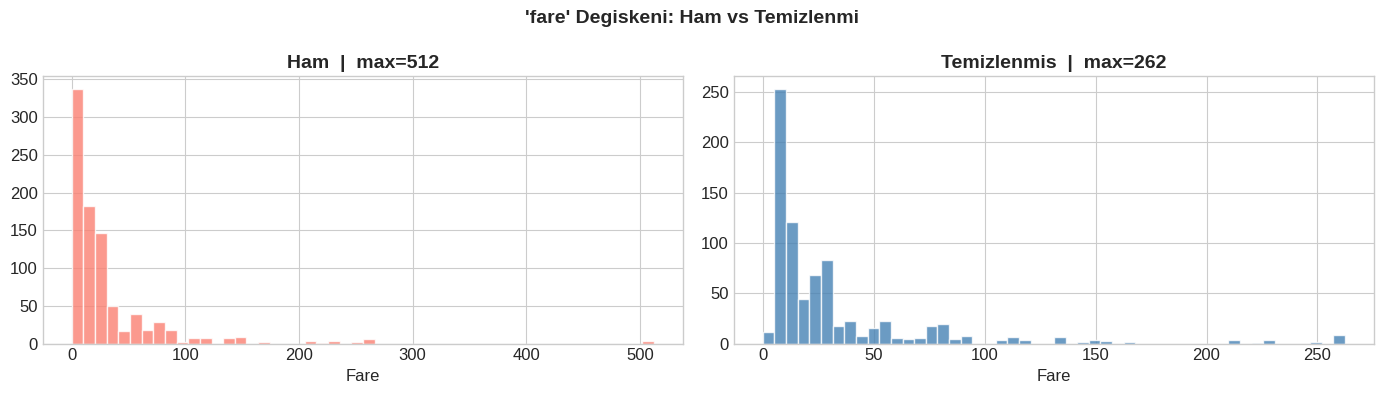

In [7]:
# ── Adım 5: Aykırı Değer İşleme — Winsorizing ──────────────
# Winsorizing: Aykırı değerleri silmek yerine sınır değerle kırpar
# Veri kaybını önler, ama bilgiyi de sıkıştırır

def winsorize(series, alt_quantile=0.01, ust_quantile=0.99):
    """
    Alt ve üst quantile dışındaki değerleri kırpar.
    Örn: alt=0.01 -> en düşük %1'i, ust=0.99 -> en yüksek %1'i sınırlar
    """
    alt = series.quantile(alt_quantile)
    ust = series.quantile(ust_quantile)
    return series.clip(lower=alt, upper=ust)

# 'fare' çok sağa çarpık -> winsorize
if 'fare' in df.columns:
    onceki_max = df['fare'].max()
    df['fare'] = winsorize(df['fare'], 0.01, 0.99)
    print(f"'fare' winsorized: max {onceki_max:.2f} -> {df['fare'].max():.2f}")

# Görselleştirme: Önce-Sonra
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle("'fare' Degiskeni: Ham vs Temizlenmi", fontsize=14, fontweight='bold')

axes[0].hist(df_raw['fare'].dropna(), bins=50, color='salmon', alpha=0.8, edgecolor='white')
axes[0].set_title(f"Ham  |  max={df_raw['fare'].max():.0f}")
axes[0].set_xlabel('Fare')

axes[1].hist(df['fare'], bins=50, color='steelblue', alpha=0.8, edgecolor='white')
axes[1].set_title(f"Temizlenmis  |  max={df['fare'].max():.0f}")
axes[1].set_xlabel('Fare')

plt.tight_layout()
plt.show()

In [8]:
# ── Adım 6: Tutarsız Değer Düzeltme ─────────────────────────
# Örnek: 'sibsp' (kardeş/eş sayısı) hiperbolik değerleri

# Veri tutarlılık kontrolü
print("Deger Aralik Kontrolleri:")
print(f"  age    : {df['age'].min():.0f} - {df['age'].max():.0f}  (Beklenen: 0-100)")
print(f"  fare   : {df['fare'].min():.2f} - {df['fare'].max():.2f}")
print(f"  sibsp  : {df['sibsp'].min()} - {df['sibsp'].max()}")
print(f"  parch  : {df['parch'].min()} - {df['parch'].max()}")
print(f"  pclass : {sorted(df['pclass'].unique())}")
print(f"  sex    : {df['sex'].unique().tolist()}")

# Temiz veri özeti
print(f"\n{'='*45}")
print(f"  TEMIZLEME TAMAMLANDI")
print(f"{'='*45}")
print(f"  Orijinal boyut   : {df_raw.shape}")
print(f"  Temizlenmi boyut : {df.shape}")
print(f"  Kaldirilan satir : {df_raw.shape[0] - df.shape[0]}")
print(f"  Kaldirilan sutun : {df_raw.shape[1] - df.shape[1]}")
print(f"  Kalan eksik      : {df.isnull().sum().sum()}")

Deger Aralik Kontrolleri:
  age    : 0 - 80  (Beklenen: 0-100)
  fare   : 0.00 - 262.38
  sibsp  : 0 - 8
  parch  : 0 - 6
  pclass : [np.int64(1), np.int64(2), np.int64(3)]
  sex    : ['male', 'female']

  TEMIZLEME TAMAMLANDI
  Orijinal boyut   : (891, 15)
  Temizlenmi boyut : (784, 9)
  Kaldirilan satir : 107
  Kaldirilan sutun : 6
  Kalan eksik      : 0


## 3. Feature Engineering — Yeni Özellik Türetme <a id="3"></a>

**Feature Engineering**, mevcut veriden yeni ve daha anlamlı özellikler üretme sürecidir.
Modelin öğrenmesi zor olan ilişkileri, daha basit bir formda sunmayı amaçlar.

### 🎯 Özellik Türetme Stratejileri

| Strateji | Açıklama | Örnek |
|---|---|---|
| **Matematiksel** | Var olan sütunlardan hesaplama | yaş × ücret |
| **İstatistiksel** | Grup bazlı istatistik | grup ortalaması |
| **Tarih/Zaman** | Tarih bileşenleri çıkarma | yıl, ay, gün, saat |
| **Metin** | String özellikler | uzunluk, kelime sayısı |
| **Etkileşim** | İki özelliğin çarpımı/bölümü | A × B |
| **Bölme (Binning)** | Sayısalı kategoriye dönüştürme | yaş grubu |
| **Polinom** | Karesel/kübik terimler | x², x³ |

> 💡 **Domain Knowledge kritiktir!** Titanic'te "kadın ve çocuklar önce" kuralı
> — `is_woman_or_child` özelliği modeli büyük ölçüde geliştirir.

In [9]:
# ══════════════════════════════════════════════════════
# BÖLÜM 3: FEATURE ENGINEERING
# ══════════════════════════════════════════════════════

df_fe = df.copy()  # Feature engineering için yeni kopya

# ── 3A. Aile Özellikleri ────────────────────────────────
# sibsp = kardes/es sayisi, parch = ebeveyn/cocuk sayisi
# Bunları birleştirerek "aile büyüklüğü" türetelim

# Toplam aile büyüklüğü (kendisi dahil)
df_fe['family_size'] = df_fe['sibsp'] + df_fe['parch'] + 1

# Yalnız mı? (aile büyüklüğü 1 ise)
df_fe['is_alone'] = (df_fe['family_size'] == 1).astype(int)

# Aile kategorisi — küçük/orta/büyük
def aile_kategori(x):
    if x == 1:   return 'Yalniz'
    elif x <= 4: return 'Kucuk'
    else:        return 'Buyuk'

df_fe['family_cat'] = df_fe['family_size'].apply(aile_kategori)

print("Aile ozellikleri olusturuldu:")
print(df_fe[['sibsp', 'parch', 'family_size', 'is_alone', 'family_cat']].head(8))
print(f"\nAile kategorisi dagilimi:")
print(df_fe['family_cat'].value_counts())

Aile ozellikleri olusturuldu:
   sibsp  parch  family_size  is_alone family_cat
0      1      0            2         0      Kucuk
1      1      0            2         0      Kucuk
2      0      0            1         1     Yalniz
3      1      0            2         0      Kucuk
4      0      0            1         1     Yalniz
5      0      0            1         1     Yalniz
6      0      0            1         1     Yalniz
7      3      1            5         0      Buyuk

Aile kategorisi dagilimi:
family_cat
Yalniz    446
Kucuk     283
Buyuk      55
Name: count, dtype: int64


In [10]:
# ── 3B. Unvan (Title) Özelliği ─────────────────────────────
# İsim sütunundan sosyal statüyü çıkarıyoruz
# Mr., Mrs., Miss., Master., Dr. vb. çok bilgi taşır

if 'name' in df_fe.columns:
    # Regex ile virgülden sonraki ilk kelimeyi (unvan) çıkar
    df_fe['title'] = df_fe['name'].str.extract(r',\s*([^\.]+)\.')
    df_fe['title'] = df_fe['title'].str.strip()

    print("Ham unvanlar:")
    print(df_fe['title'].value_counts())

    # Nadir unvanları gruplayalım
    nadir_unvanlar = df_fe['title'].value_counts()
    nadir_unvanlar = nadir_unvanlar[nadir_unvanlar < 10].index.tolist()

    def unvan_grupla(unvan):
        if unvan in ['Mr']:             return 'Mr'
        elif unvan in ['Miss', 'Ms', 'Mlle', 'Mme']: return 'Miss'
        elif unvan in ['Mrs']:          return 'Mrs'
        elif unvan in ['Master']:       return 'Master'
        else:                           return 'Diger'

    df_fe['title_grouped'] = df_fe['title'].apply(unvan_grupla)

    print("\nGruplanmis unvanlar:")
    print(df_fe['title_grouped'].value_counts())

    # Unvandan yaş tahmin et (eksik yaşları doldurmak için kullanılabilir)
    print("\nUnvan bazinda ort yas:")
    print(df_fe.groupby('title_grouped')['age'].agg(['mean', 'median', 'count']).round(1))

Yas grubu dagilimi:
age_group
Cocuk        68
Ergen        67
Genc        435
Orta_Yas    192
Yasli        22
Name: count, dtype: int64


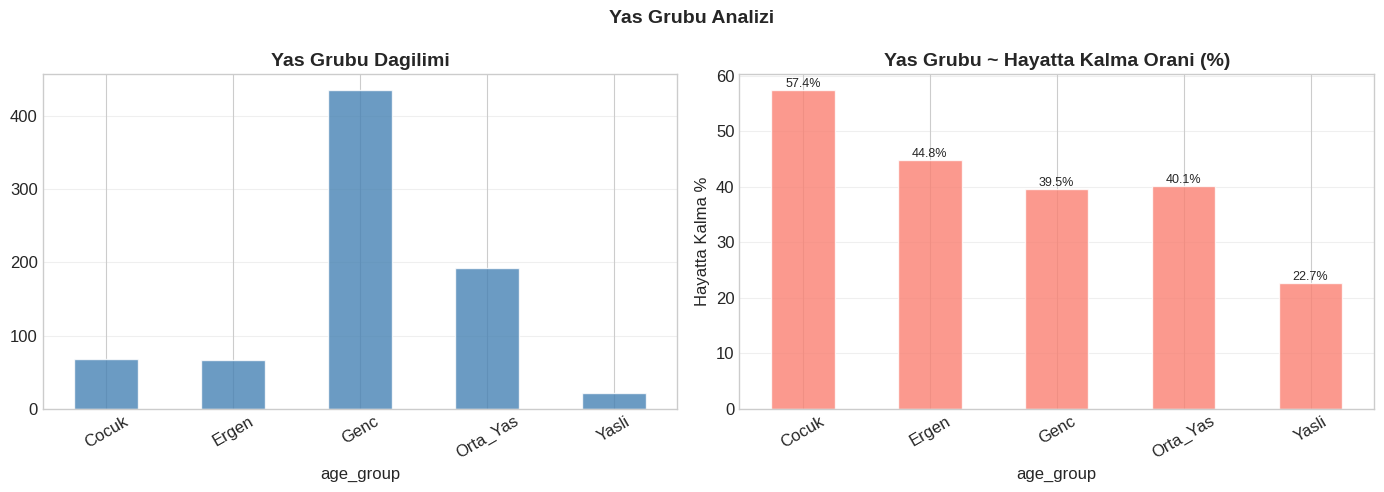

In [11]:
# ── 3C. Yaş Gruplama (Binning) ──────────────────────────────
# Sayısal yaşı anlamlı kategorilere böl
# Titanic'te "çocuk/genç/orta yaş/yaşlı" ayrımı önemlidir

df_fe['age_group'] = pd.cut(
    df_fe['age'],
    bins=[0, 12, 18, 35, 60, 100],
    labels=['Cocuk', 'Ergen', 'Genc', 'Orta_Yas', 'Yasli'],
    right=True
)

print("Yas grubu dagilimi:")
print(df_fe['age_group'].value_counts().sort_index())

# Hayatta kalma oranı yaş grubuna göre
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Yas Grubu Analizi", fontsize=14, fontweight='bold')

# 1. Frekans dağılımı
df_fe['age_group'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color='steelblue', alpha=0.8, edgecolor='white'
)
axes[0].set_title('Yas Grubu Dagilimi')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30)
axes[0].grid(True, alpha=0.3, axis='y')

# 2. Hayatta kalma oranı
surv_rate = df_fe.groupby('age_group', observed=True)['survived'].mean() * 100
surv_rate.plot(kind='bar', ax=axes[1], color='salmon', alpha=0.8, edgecolor='white')
axes[1].set_title('Yas Grubu ~ Hayatta Kalma Orani (%)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30)
axes[1].set_ylabel('Hayatta Kalma %')
axes[1].grid(True, alpha=0.3, axis='y')
for bar in axes[1].patches:
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{bar.get_height():.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [12]:
# ── 3D. Ücret Kategorisi + Log Dönüşümü ─────────────────────
# Ücret çok sağa çarpık -> log dönüşümü ile normalleştir
# Ayrıca ücret grubunu türet

# Log dönüşümü (log1p = log(1+x), sıfır değerler için güvenli)
df_fe['fare_log'] = np.log1p(df_fe['fare'])

# Ücret gruplama (quantile bazlı — eşit sayıda gözlem)
df_fe['fare_group'] = pd.qcut(
    df_fe['fare'],
    q=4,
    labels=['Ucuz', 'Ekonomi', 'Konfor', 'Luks']
)

# ── 3E. Etkileşim Özellikleri (Interaction Features) ────────
# Cinsiyet + Sınıf etkileşimi — çok güçlü bir özellik
df_fe['sex_pclass'] = df_fe['sex'].astype(str) + '_' + df_fe['pclass'].astype(str)

# Yalnız + Sınıf
df_fe['alone_pclass'] = df_fe['is_alone'].astype(str) + '_' + df_fe['pclass'].astype(str)

# ── 3F. Domain Knowledge: Kadın veya Çocuk ─────────────────
# Titanic'te "women and children first" kuralı uygulandı
# Bu özellik survival ile çok güçlü ilişkilidir
df_fe['is_woman_or_child'] = (
    (df_fe['sex'] == 'female') | (df_fe['age'] <= 12)
).astype(int)

surv_oran = df_fe.groupby('is_woman_or_child')['survived'].mean() * 100
print("Kadin veya Cocuk - Hayatta Kalma Orani:")
print(f"  Hayir (0): %{surv_oran.get(0, 0):.1f}")
print(f"  Evet  (1): %{surv_oran.get(1, 0):.1f}")

print(f"\nToplam feature sayisi: {df_fe.shape[1]} (orijinal: {df.shape[1]})")
print("Yeni ozellikler:", [c for c in df_fe.columns if c not in df.columns])

Kadin veya Cocuk - Hayatta Kalma Orani:
  Hayir (0): %18.7
  Evet  (1): %72.1

Toplam feature sayisi: 18 (orijinal: 9)
Yeni ozellikler: ['family_size', 'is_alone', 'family_cat', 'age_group', 'fare_log', 'fare_group', 'sex_pclass', 'alone_pclass', 'is_woman_or_child']


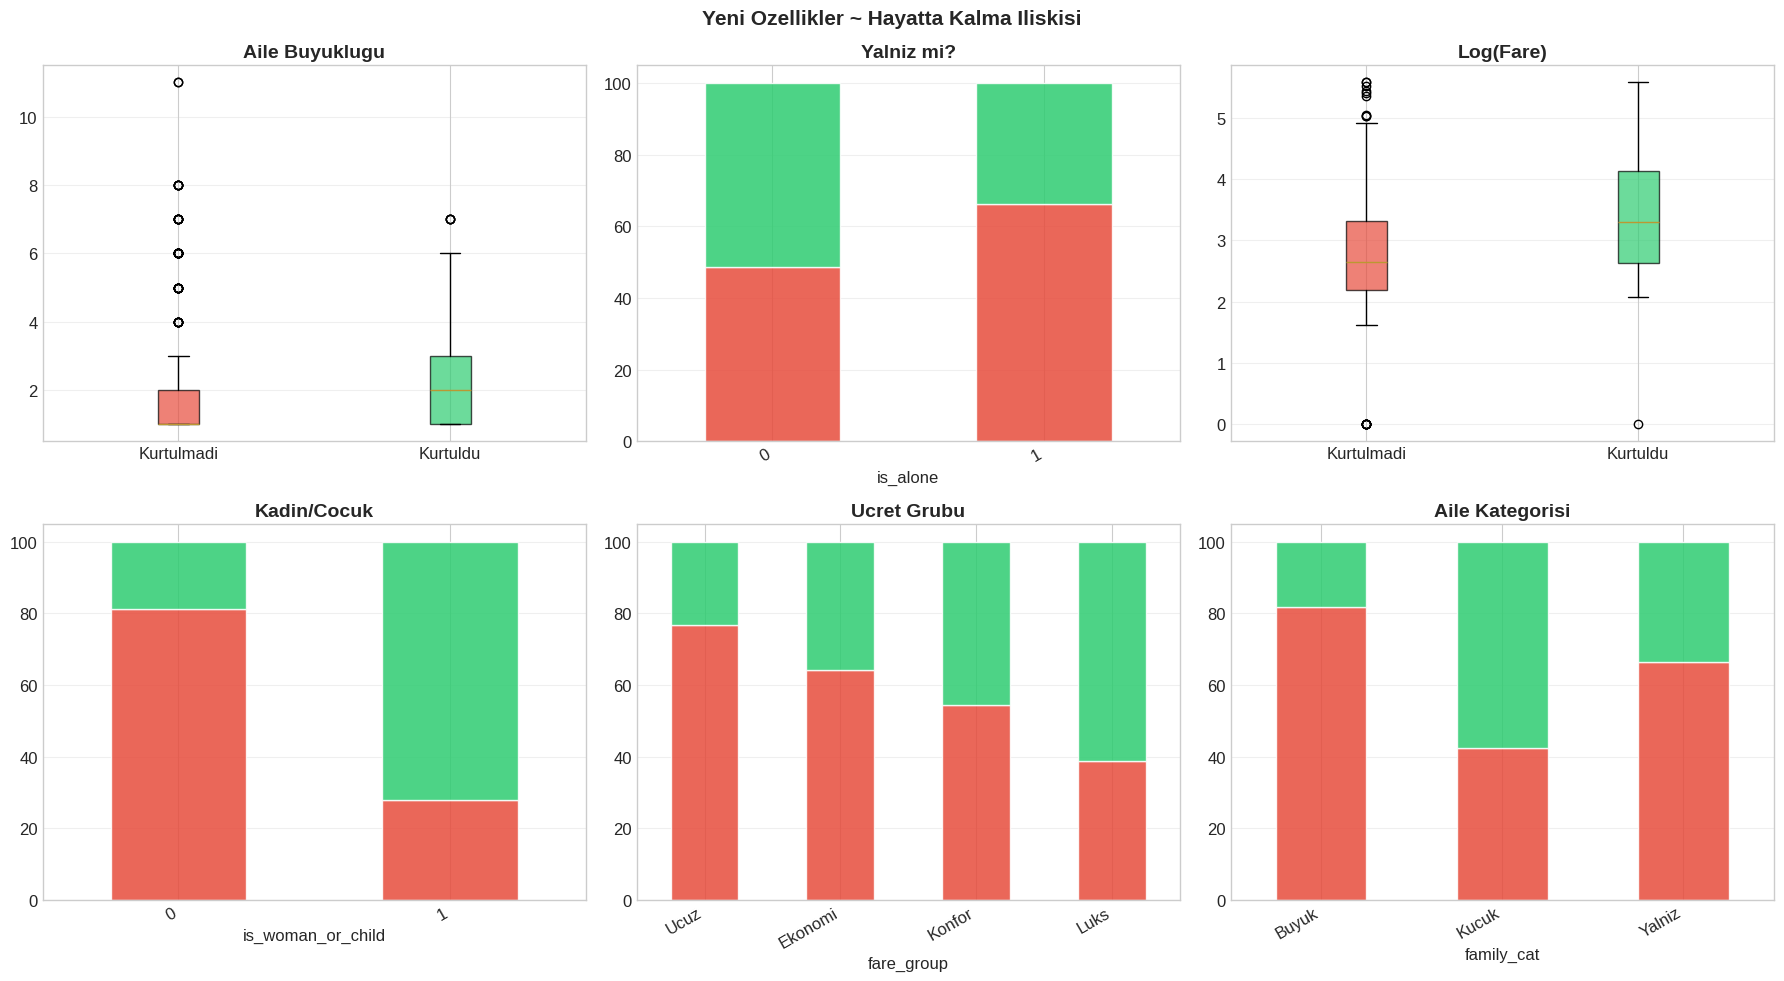

In [13]:
# ── 3G. Feature Engineering Özet Görselleştirme ────────────
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Yeni Ozellikler ~ Hayatta Kalma Iliskisi", fontsize=15, fontweight='bold')

ozellik_listesi = [
    ('family_size',        'Aile Buyuklugu'),
    ('is_alone',           'Yalniz mi?'),
    ('fare_log',           'Log(Fare)'),
    ('is_woman_or_child',  'Kadin/Cocuk'),
    ('fare_group',         'Ucret Grubu'),
    ('family_cat',         'Aile Kategorisi'),
]

renkler = ['#E74C3C', '#2ECC71']

for ax, (ozellik, baslik) in zip(axes.flat, ozellik_listesi):
    if ozellik in df_fe.columns:
        if df_fe[ozellik].dtype in ['float64', 'int64'] and df_fe[ozellik].nunique() > 5:
            # Sürekli değişken -> Box plot
            gruplar = [df_fe[df_fe['survived']==0][ozellik].dropna().values,
                       df_fe[df_fe['survived']==1][ozellik].dropna().values]
            bp = ax.boxplot(gruplar, patch_artist=True, labels=['Kurtulmadi', 'Kurtuldu'])
            bp['boxes'][0].set_facecolor(renkler[0])
            bp['boxes'][1].set_facecolor(renkler[1])
            for p in bp['boxes']:
                p.set_alpha(0.7)
        else:
            # Kategorik -> Stacked bar
            ct = pd.crosstab(df_fe[ozellik], df_fe['survived'], normalize='index') * 100
            ct.columns = ['Kurtulmadi', 'Kurtuldu']
            ct.plot(kind='bar', stacked=True, ax=ax,
                    color=renkler, alpha=0.85, edgecolor='white', legend=(ax == axes.flat[0]))
            ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

        ax.set_title(baslik)
        ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 4. Encoding — Kategorik -> Sayısal <a id="4"></a>

Makine öğrenmesi algoritmaları sayısal verilerle çalışır.
Kategorik değişkenleri sayısala dönüştürme işlemine **encoding** denir.

### 🔢 Encoding Yöntemleri

| Yöntem | Ne Zaman? | Örnek | Avantaj | Dezavantaj |
|---|---|---|---|---|
| **Label Encoding** | Sıralı kategorik | Düşük/Orta/Yüksek -> 0/1/2 | Basit | Yanlış sıra izlenimi |
| **One-Hot Encoding** | Nominal, az kategori (≤15) | Renk -> [1,0,0],[0,1,0] | Sıra yok | Yüksek boyut |
| **Ordinal Encoding** | Açıkça sıralı | S/M/L/XL -> 0/1/2/3 | Sıra korunur | Manuel tanım |
| **Target Encoding** | Yüksek kardinalite | Şehir -> ort. hedef | Az boyut | Data leakage riski |
| **Binary Encoding** | Orta kardinalite | 100 kategori -> 7 bit | Compact | Zor yorumlanır |
| **Frequency Encoding** | Kardinalite bağımsız | Kategori -> frekansı | Basit | Sıra bilgisi yok |

> ⚠️ **Label Encoding'i nominal (sırasız) değişkenlere uygulamayın!**
> Algoritma aralarında yanlış bir sayısal sıra ilişkisi kurar.

In [14]:
# ══════════════════════════════════════════════════════
# BÖLÜM 4: ENCODING
# ══════════════════════════════════════════════════════

df_enc = df_fe.copy()

# Encoding için kullanacağımız sütunları belirle
# (gereksiz veya zaten sayısal olanları dışla)
hedef = 'survived'
kullanilmayacak = ['name', 'ticket', 'cabin', 'title', 'age_group',
                    'fare_group', 'family_cat', 'sex_pclass', 'alone_pclass']
mevcut_kullanilmayacak = [c for c in kullanilmayacak if c in df_enc.columns]
df_enc = df_enc.drop(columns=mevcut_kullanilmayacak)

print("Encoding oncesi sutunlar:")
for col in df_enc.columns:
    print(f"  {col:20s} {str(df_enc[col].dtype):15s} {df_enc[col].nunique():>5} benzersiz")

Encoding oncesi sutunlar:
  survived             int64               2 benzersiz
  pclass               int64               3 benzersiz
  sex                  category            2 benzersiz
  age                  float64            89 benzersiz
  sibsp                int64               7 benzersiz
  parch                int64               7 benzersiz
  fare                 float64           246 benzersiz
  embarked             category            3 benzersiz
  alone                bool                2 benzersiz
  family_size          int64               9 benzersiz
  is_alone             int64               2 benzersiz
  fare_log             float64           246 benzersiz
  is_woman_or_child    int64               2 benzersiz


In [15]:
# ── 4A. One-Hot Encoding ────────────────────────────────────
# Nominal kategorik değişkenler için en güvenli yöntem
# pd.get_dummies() ile hızlı uygulama
# drop_first=True -> dummy variable trap'i önler (k-1 sütun yeter)

print("One-Hot Encoding uygulanıyor...")
print(f"  Onceki boyut: {df_enc.shape}")

ohe_sutunlar = ['embarked']
df_enc = pd.get_dummies(
    df_enc,
    columns=ohe_sutunlar,
    drop_first=True,   # Çoklu doğrusallığı önlemek için ilk kategoriyi düşür
    prefix_sep='_',
    dtype=int          # Boolean yerine 0/1 integer
)

print(f"  Sonraki boyut: {df_enc.shape}")
print(f"  Yeni sutunlar: {[c for c in df_enc.columns if 'embarked' in c]}")

One-Hot Encoding uygulanıyor...
  Onceki boyut: (784, 13)
  Sonraki boyut: (784, 14)
  Yeni sutunlar: ['embarked_Q', 'embarked_S']


In [16]:
# ── 4B. Binary Encoding (sex) ───────────────────────────────
# 2 kategorili değişken için label encoding uygundur
# 'sex': female=0, male=1

if 'sex' in df_enc.columns:
    df_enc['sex'] = df_enc['sex'].map({'female': 0, 'male': 1})
    # map() ile dict kullanımı — Series.map() dict kabul eder
    # ama dict-like callable yerine doğrudan map kullanıyoruz
    df_enc['sex'] = df_enc['sex'].fillna(0).astype(int)
    print("'sex' encoding: female=0, male=1")
    print(df_enc['sex'].value_counts())

'sex' encoding: female=0, male=1
sex
1    491
0    293
Name: count, dtype: int64


In [17]:
# ── 4C. Tüm Encoding Yöntemlerini Karşılaştır (Iris) ─────────
# Iris dataset'inde 'species' sütununu farklı yöntemlerle encode et

print("\n--- Encoding Yontemleri Karsilastirma (Iris Species) ---\n")
iris_enc = iris.copy()

# 1. Label Encoding
le = LabelEncoder()
iris_enc['species_label'] = le.fit_transform(iris_enc['species'])
print("1. Label Encoding:")
print(dict(zip(le.classes_, le.transform(le.classes_))))

# 2. One-Hot Encoding (get_dummies)
ohe_df = pd.get_dummies(iris_enc['species'], prefix='species', dtype=int)
print("\n2. One-Hot Encoding (ilk 3 satir):")
print(ohe_df.head(3))

# 3. Ordinal Encoding (manuel sıra tanımlı)
ordinal_map = {'setosa': 0, 'versicolor': 1, 'virginica': 2}
iris_enc['species_ordinal'] = iris_enc['species'].map(ordinal_map)
print("\n3. Ordinal Encoding (manuel):")
print(iris_enc[['species', 'species_ordinal']].drop_duplicates())

# 4. Frequency Encoding — her kategorinin frekansıyla değiştir
freq_map = iris_enc['species'].value_counts().to_dict()
iris_enc['species_freq'] = iris_enc['species'].map(freq_map)
print("\n4. Frequency Encoding:")
print(iris_enc[['species', 'species_freq']].drop_duplicates())


--- Encoding Yontemleri Karsilastirma (Iris Species) ---

1. Label Encoding:
{'setosa': np.int64(0), 'versicolor': np.int64(1), 'virginica': np.int64(2)}

2. One-Hot Encoding (ilk 3 satir):
   species_setosa  species_versicolor  species_virginica
0               1                   0                  0
1               1                   0                  0
2               1                   0                  0

3. Ordinal Encoding (manuel):
        species  species_ordinal
0        setosa                0
50   versicolor                1
100   virginica                2

4. Frequency Encoding:
        species  species_freq
0        setosa            50
50   versicolor            50
100   virginica            50


In [21]:
# ── 4D. Target Encoding ─────────────────────────────────────
# Yüksek kardinaliteli kategorik değişkenler için güçlü bir yöntem
# Her kategoriye, o kategorideki hedef değişkenin ortalaması atanır
# DİKKAT: Eğitim verisinde hesaplanmalı, test verisine uygulanmalı!

def target_encoding(df, kategorik_sutun, hedef_sutun, smoothing=1.0):
    """
    Smoothed Target Encoding.
    smoothing: Küçük gruplarda global ortalamaya yönelme katsayisi
    """
    global_mean = df[hedef_sutun].mean()
    grup_stats  = df.groupby(kategorik_sutun)[hedef_sutun].agg(['mean', 'count'])

    # Smoothed encoding: küçük gruplar global ortalamayla karışır
    smoothed = (grup_stats['count'] * grup_stats['mean'] + smoothing * global_mean) /                (grup_stats['count'] + smoothing)

    return df[kategorik_sutun].map(smoothed)

# Örnek: 'embarked' için target encoding (eğitim setinde hesaplanmali!)
if 'embarked' in df_fe.columns:
    df_target_ex = df_fe[['embarked', 'survived']].dropna().copy()
    df_target_ex['embarked'] = df_target_ex['embarked'].astype(str)  # category → str

    df_target_ex['embarked_target_enc'] = target_encoding(
        df_target_ex, 'embarked', 'survived', smoothing=5
    )
    print("Target Encoding ornegi ('embarked'):")
    ozet = df_target_ex.groupby('embarked')[['survived', 'embarked_target_enc']].mean().round(3)
    print(ozet)
    print("\n(Hedef ortalama ile target encoding degeri neredeyse esit olur)")

# Encoding sonucu kontrol
print(f"\nEncoding tamamlandi. Son veri boyutu: {df_enc.shape}")
print(f"Kategorik sutun kaldi mi? {df_enc.select_dtypes(include='category').columns.tolist()}")

Target Encoding ornegi ('embarked'):
          survived  embarked_target_enc
embarked                               
C            0.581                0.575
Q            0.339                0.345
S            0.374                0.374

(Hedef ortalama ile target encoding degeri neredeyse esit olur)

Encoding tamamlandi. Son veri boyutu: (784, 14)
Kategorik sutun kaldi mi? []


## 5. Scaling — Özellik Ölçeklendirme <a id="5"></a>

**Scaling**, sayısal özelliklerin farklı ölçeklerde olmasından kaynaklanan sorunları giderir.

### 🎯 Neden Gerekli?

KNN, SVM, lojistik regresyon, sinir ağları gibi **mesafe veya gradyan tabanlı** algoritmalar,
büyük ölçekli özelliklerden etkilenir. Örneğin `age ∈ [0,80]` ile `fare ∈ [0,500]` doğrudan
karşılaştırılamaz.

> ⚠️ **Ağaç tabanlı algoritmalar** (Random Forest, XGBoost) scaling gerektirmez.

### 📐 Yöntemler

| Yöntem | Formül | Aralık | Ne Zaman? |
|---|---|---|---|
| **StandardScaler** | (x - μ) / σ | ≈[-3, +3] | Normal dağılım, aykırı yoksa |
| **MinMaxScaler** | (x - min) / (max - min) | [0, 1] | Dağılım biliniyorsa |
| **RobustScaler** | (x - Q2) / IQR | Değişken | Aykırı değer varsa |
| **MaxAbsScaler** | x / max(|x|) | [-1, +1] | Seyrek (sparse) veri |
| **PowerTransformer** | Yeo-Johnson/Box-Cox | ≈normal | Çarpık dağılım |

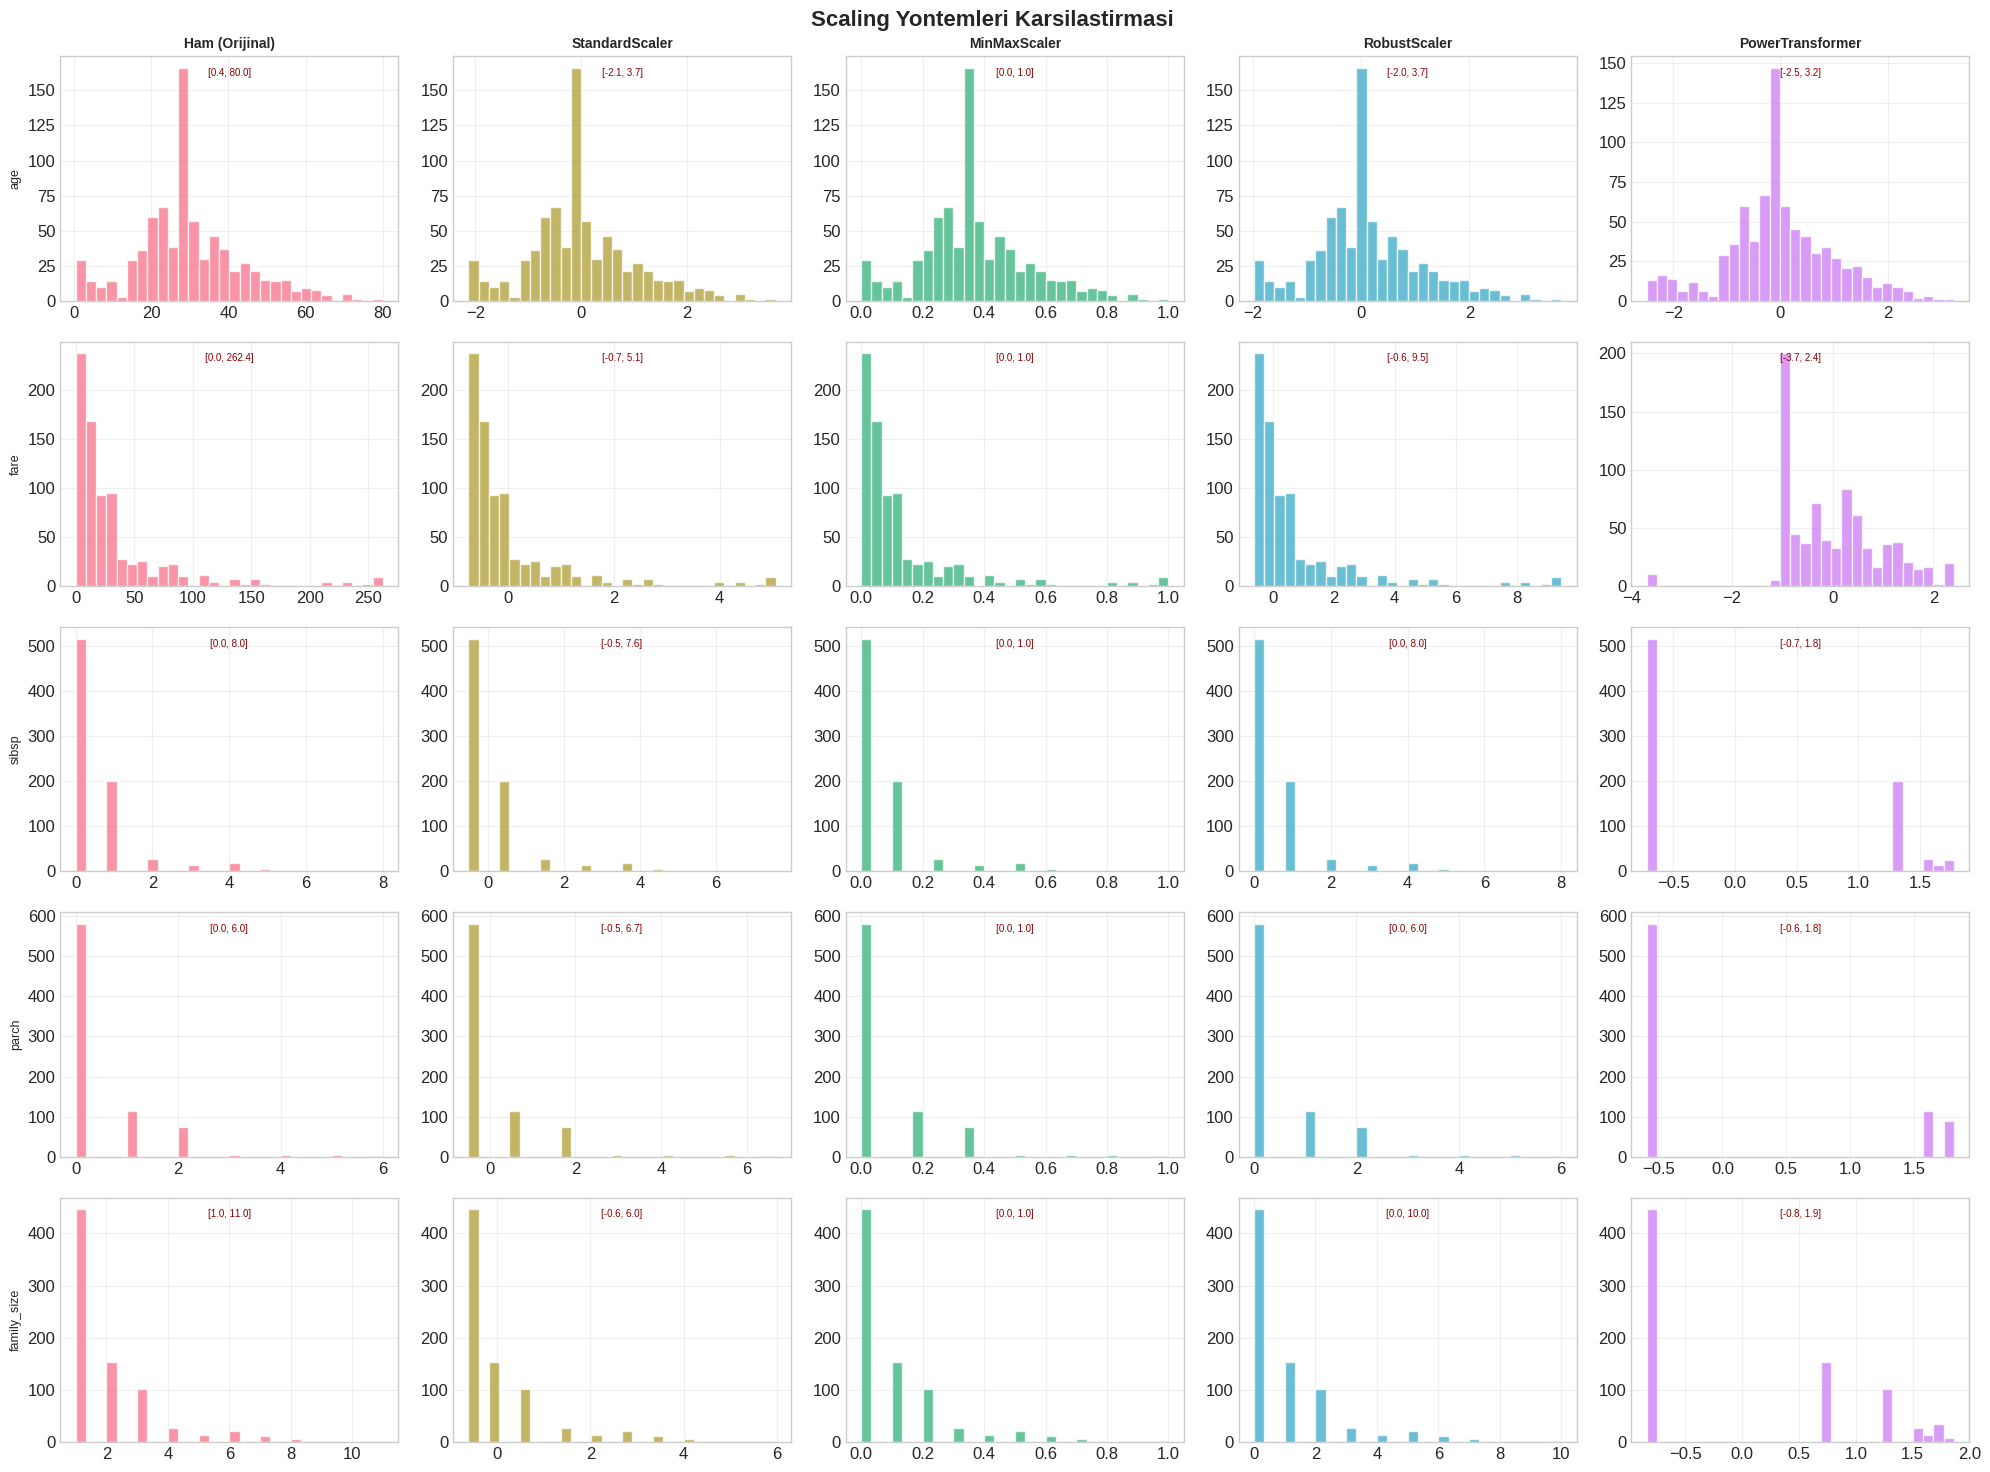

In [22]:
# ══════════════════════════════════════════════════════
# BÖLÜM 5: SCALING
# ══════════════════════════════════════════════════════

# Karşılaştırma için sayısal değişkenleri al
sayisal = ['age', 'fare', 'sibsp', 'parch', 'family_size']
sayisal = [c for c in sayisal if c in df_enc.columns]

X_ornek = df_enc[sayisal].copy()

# ── Tüm scaler'ları uygula ve karşılaştır ────────────
scalerlar = {
    'Ham (Orijinal)' : None,
    'StandardScaler' : StandardScaler(),
    'MinMaxScaler'   : MinMaxScaler(),
    'RobustScaler'   : RobustScaler(),
    'PowerTransformer': PowerTransformer(method='yeo-johnson')
}

fig, axes = plt.subplots(len(sayisal), len(scalerlar), figsize=(20, 3*len(sayisal)))
fig.suptitle("Scaling Yontemleri Karsilastirmasi", fontsize=16, fontweight='bold')

for j, (isim, scaler) in enumerate(scalerlar.items()):
    if scaler is None:
        X_scaled = X_ornek.values
    else:
        X_scaled = scaler.fit_transform(X_ornek)

    for i, sutun in enumerate(sayisal):
        ax = axes[i, j]
        ax.hist(X_scaled[:, i], bins=30, alpha=0.75,
                color=sns.color_palette("husl", len(scalerlar))[j],
                edgecolor='white')

        if i == 0:
            ax.set_title(isim, fontsize=10, fontweight='bold')
        if j == 0:
            ax.set_ylabel(sutun, fontsize=9)

        # Aralık bilgisi
        mn, mx = X_scaled[:, i].min(), X_scaled[:, i].max()
        ax.text(0.5, 0.92, f'[{mn:.1f}, {mx:.1f}]',
                transform=ax.transAxes, ha='center', fontsize=7,
                color='darkred')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:
# ── Scaling: Train/Test Ayrımı ile Doğru Uygulama ──────────
# KRITIK: Scaler SADECE eğitim verisine fit edilmeli!
# Test verisine sadece transform uygulanmalı
# Aksi halde "data leakage" oluşur

print("DOGRU Scaling Akisi:")
print("=" * 50)

# Veri hazırlama
X = df_enc.drop(columns=[hedef])
y = df_enc[hedef]

# Sadece sayısal sütunları al
X_sayisal = X.select_dtypes(include=np.number)

# Train/Test ayırımı
X_train, X_test, y_train, y_test = train_test_split(
    X_sayisal, y, test_size=0.2, random_state=42, stratify=y
)

print(f"  Train boyutu: {X_train.shape}")
print(f"  Test boyutu : {X_test.shape}")
print(f"  Hedef dagilim (train): {y_train.value_counts(normalize=True).round(3).to_dict()}")

# Scaler'ı SADECE train üzerinde fit et
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # fit + transform
X_test_scaled  = scaler.transform(X_test)         # SADECE transform!

print(f"\n  Train (scaled) ort/std: {X_train_scaled.mean():.4f} / {X_train_scaled.std():.4f}")
print(f"  Test  (scaled) ort/std: {X_test_scaled.mean():.4f} / {X_test_scaled.std():.4f}")
print("\n  (Test std ~1 degil cunku test scaler'a fit edilmedi — bu DOGRU)")
print()
print("YAN HATALI YAKLASIM: scaler.fit_transform(X_test)")
print("   -> Test verisi ile scaler'in fit edilmesi bilgi sizintisinа yol acar!")

DOGRU Scaling Akisi:
  Train boyutu: (627, 12)
  Test boyutu : (157, 12)
  Hedef dagilim (train): {0: 0.589, 1: 0.411}

  Train (scaled) ort/std: 0.0000 / 1.0000
  Test  (scaled) ort/std: 0.0187 / 1.0074

  (Test std ~1 degil cunku test scaler'a fit edilmedi — bu DOGRU)

YAN HATALI YAKLASIM: scaler.fit_transform(X_test)
   -> Test verisi ile scaler'in fit edilmesi bilgi sizintisinа yol acar!


## 6. Feature Selection — Özellik Seçimi <a id="6"></a>

**Feature Selection**, modeli eğitmek için en bilgilendirici özellikleri seçme sürecidir.

### 🎯 Neden Önemli?

- **Boyutun laneti (Curse of Dimensionality)**: Çok fazla özellik modeli bozar
- **Overfitting**: Gereksiz özellikler modelin ezber yapmasına yol açar
- **Hesaplama maliyeti**: Daha az özellik = daha hızlı model
- **Yorumlanabilirlik**: Az özellik = anlaşılır model

### 📊 Yöntemler

```
Feature Selection
├── Filter Methods    (modelden bağımsız)
│   ├── Variance Threshold
│   ├── Correlation Analysis
│   ├── Chi-Square Test
│   └── Mutual Information
├── Wrapper Methods   (modele bağlı, yavaş ama iyi)
│   ├── RFE (Recursive Feature Elimination)
│   └── Forward/Backward Selection
└── Embedded Methods  (model içinde)
    ├── Lasso (L1 Regularization)
    ├── Ridge (L2)
    └── Tree Feature Importance
```

In [24]:
# ══════════════════════════════════════════════════════
# BÖLÜM 6: FEATURE SELECTION
# ══════════════════════════════════════════════════════

# ── 6A. Variance Threshold ──────────────────────────────
# Varyansı çok düşük (neredeyse sabit) özellikler bilgi taşımaz

vt = VarianceThreshold(threshold=0.01)  # Varyans < 0.01 -> kaldır
vt.fit(X_train_scaled)

dusuk_varyas = X_train.columns[~vt.get_support()].tolist()
print("Dusuk Varyansi Sutunlar (kaldirilabilir):")
if dusuk_varyas:
    for col in dusuk_varyas:
        var = X_train[col].var()
        print(f"  {col}: var={var:.6f}")
else:
    print("  Tum sutunlar yeterli varyansa sahip.")

Dusuk Varyansi Sutunlar (kaldirilabilir):
  Tum sutunlar yeterli varyansa sahip.


Yuksek Korelasyonlu Ciftler (|r| > 0.85):
  sex <-> is_woman_or_child: r=0.892
  sibsp <-> family_size: r=0.864


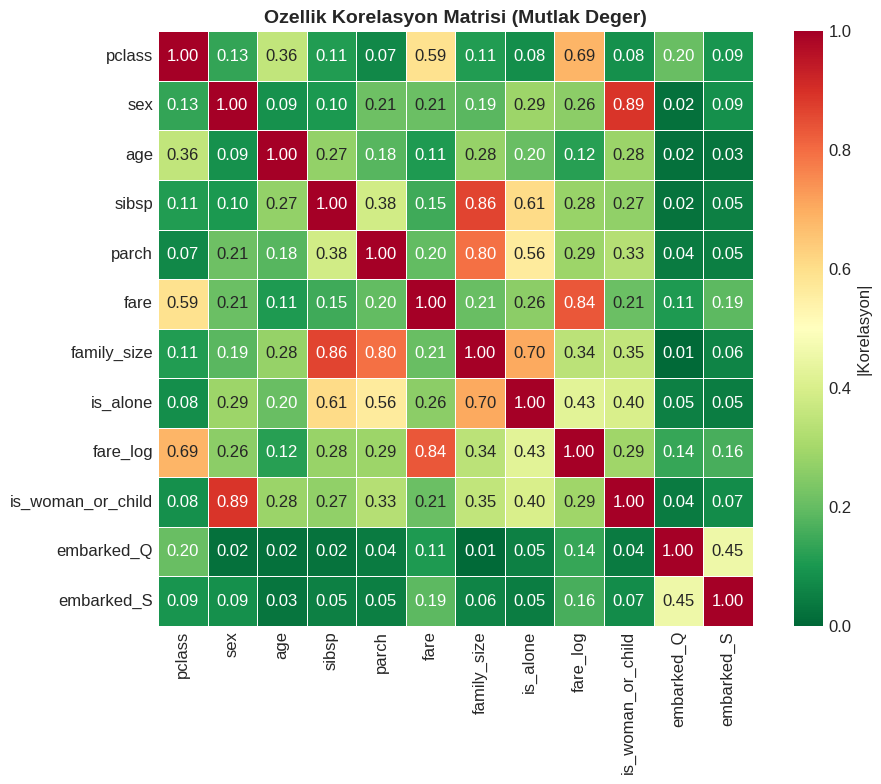

In [25]:
# ── 6B. Korelasyon Bazlı Seçim ──────────────────────────────
# Birbirine çok yüksek korelasyonlu özellikler tekrarlı bilgi taşır
# Birini tutup diğerini kaldırabiliriz

korr_matrix = X_train.corr().abs()
yuksel_korr_cifler = []

for i in range(len(korr_matrix.columns)):
    for j in range(i+1, len(korr_matrix.columns)):
        if korr_matrix.iloc[i, j] > 0.85:
            yuksel_korr_cifler.append((
                korr_matrix.columns[i],
                korr_matrix.columns[j],
                korr_matrix.iloc[i, j]
            ))

if yuksel_korr_cifler:
    print("Yuksek Korelasyonlu Ciftler (|r| > 0.85):")
    for v1, v2, r in yuksel_korr_cifler:
        print(f"  {v1} <-> {v2}: r={r:.3f}")
else:
    print("Yuksek korelasyonlu cift yok.")

# Korelasyon heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(korr_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r',
            center=0.5, vmin=0, vmax=1, square=True,
            linewidths=0.5, cbar_kws={'label': '|Korelasyon|'})
plt.title("Ozellik Korelasyon Matrisi (Mutlak Deger)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Ozellik Onem Skorlari (Mutual Information'a gore):


,Ozellik,F_Score,F_pValue,MI_Score
9,is_woman_or_child,228.4857,0.0000,0.1346
1,sex,197.2895,0.0000,0.0934
8,fare_log,73.2538,0.0000,0.0888
5,fare,46.4510,0.0000,0.0832
6,family_size,0.2096,0.6472,0.0674
0,pclass,84.3908,0.0000,0.0541
7,is_alone,22.6958,0.0000,0.0230
2,age,5.1520,0.0236,0.0219
10,embarked_Q,3.0136,0.0831,0.0194
3,sibsp,0.1589,0.6903,0.0143


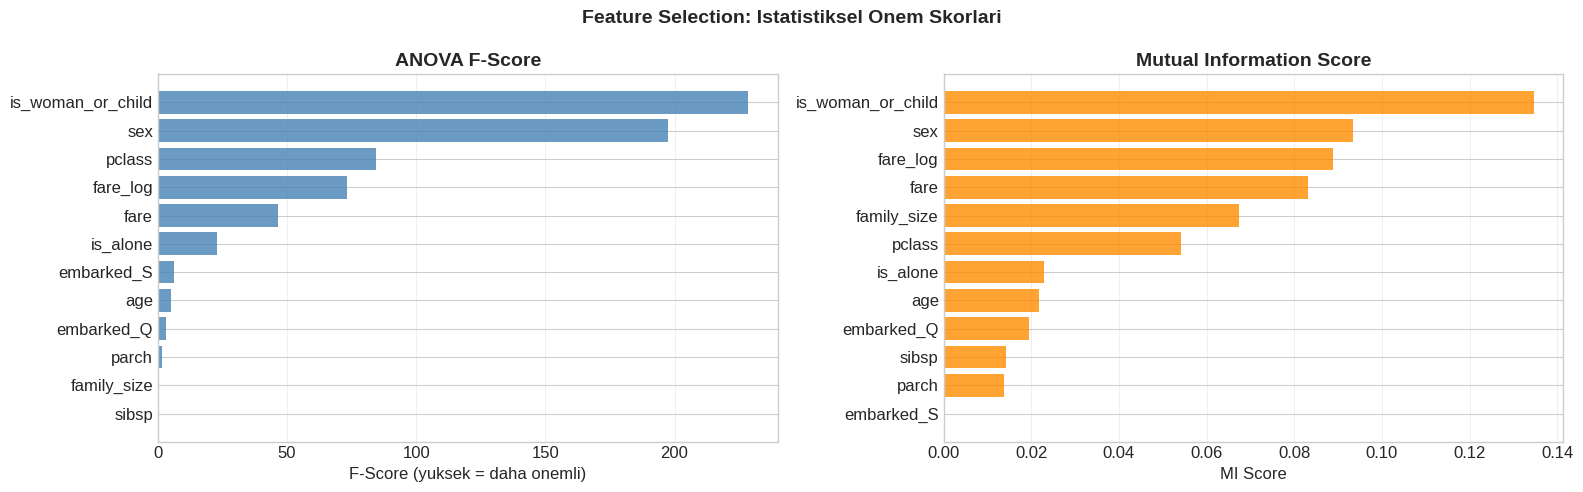

In [26]:
# ── 6C. SelectKBest: İstatistiksel Önem Skorları ─────────────
# ANOVA F-testi: Sayısal özellikler için
# Mutual Information: Lineer olmayan ilişkileri de yakalar

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# ANOVA F-test
selector_f = SelectKBest(score_func=f_classif, k='all')
selector_f.fit(X_train_scaled, y_train)

# Mutual Information
selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
selector_mi.fit(X_train_scaled, y_train)

# Sonuçları birleştir
importance_df = pd.DataFrame({
    'Ozellik'   : X_train.columns,
    'F_Score'   : selector_f.scores_,
    'F_pValue'  : selector_f.pvalues_,
    'MI_Score'  : selector_mi.scores_,
}).sort_values('MI_Score', ascending=False)

print("Ozellik Onem Skorlari (Mutual Information'a gore):")
display(importance_df.round(4))

# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Feature Selection: Istatistiksel Onem Skorlari", fontsize=14, fontweight='bold')

# F-Score
sira = importance_df.sort_values('F_Score', ascending=True)
axes[0].barh(sira['Ozellik'], sira['F_Score'], color='steelblue', alpha=0.8)
axes[0].set_title('ANOVA F-Score')
axes[0].set_xlabel('F-Score (yuksek = daha onemli)')
axes[0].grid(True, alpha=0.3, axis='x')

# Mutual Information
sira2 = importance_df.sort_values('MI_Score', ascending=True)
axes[1].barh(sira2['Ozellik'], sira2['MI_Score'], color='darkorange', alpha=0.8)
axes[1].set_title('Mutual Information Score')
axes[1].set_xlabel('MI Score')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

Optimal ozellik sayisi: 12
Secilen ozellikler:
  + pclass
  + sex
  + age
  + sibsp
  + parch
  + fare
  + family_size
  + is_alone
  + fare_log
  + is_woman_or_child
  + embarked_Q
  + embarked_S
Cikarilan ozellikler: []


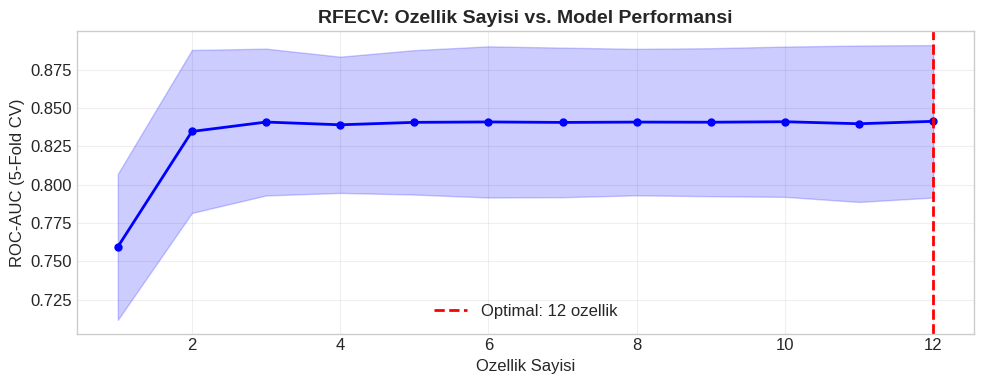

In [27]:
# ── 6D. RFE — Recursive Feature Elimination ─────────────────
# Zayıf özellikleri birer birer çıkararak en iyi alt kümeyi bulur
# Her adımda modeli yeniden eğitir -> yavaş ama etkili

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

rfe_model = LogisticRegression(max_iter=500, random_state=42)
rfecv = RFECV(
    estimator   = rfe_model,
    step        = 1,          # Her adımda 1 özellik çıkar
    cv          = StratifiedKFold(5),
    scoring     = 'roc_auc',
    n_jobs      = -1
)
rfecv.fit(X_train_scaled, y_train)

print(f"Optimal ozellik sayisi: {rfecv.n_features_}")
print(f"Secilen ozellikler:")
secilen = X_train.columns[rfecv.support_].tolist()
for f in secilen:
    print(f"  + {f}")

cikarilan = X_train.columns[~rfecv.support_].tolist()
print(f"Cikarilan ozellikler: {cikarilan}")

# RFE CV skoru grafiği
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score'])+1),
         rfecv.cv_results_['mean_test_score'],
         'b-o', markersize=5, linewidth=2)
plt.fill_between(
    range(1, len(rfecv.cv_results_['mean_test_score'])+1),
    rfecv.cv_results_['mean_test_score'] - rfecv.cv_results_['std_test_score'],
    rfecv.cv_results_['mean_test_score'] + rfecv.cv_results_['std_test_score'],
    alpha=0.2, color='blue'
)
plt.axvline(rfecv.n_features_, color='red', ls='--', lw=2,
            label=f'Optimal: {rfecv.n_features_} ozellik')
plt.xlabel('Ozellik Sayisi')
plt.ylabel('ROC-AUC (5-Fold CV)')
plt.title('RFECV: Ozellik Sayisi vs. Model Performansi')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Random Forest Feature Importance:


,Ozellik,Onem
2,age,0.2348
5,fare,0.1565
8,fare_log,0.1555
9,is_woman_or_child,0.1433
1,sex,0.1115
0,pclass,0.0731
6,family_size,0.0449
3,sibsp,0.0281
11,embarked_S,0.0186
4,parch,0.0183


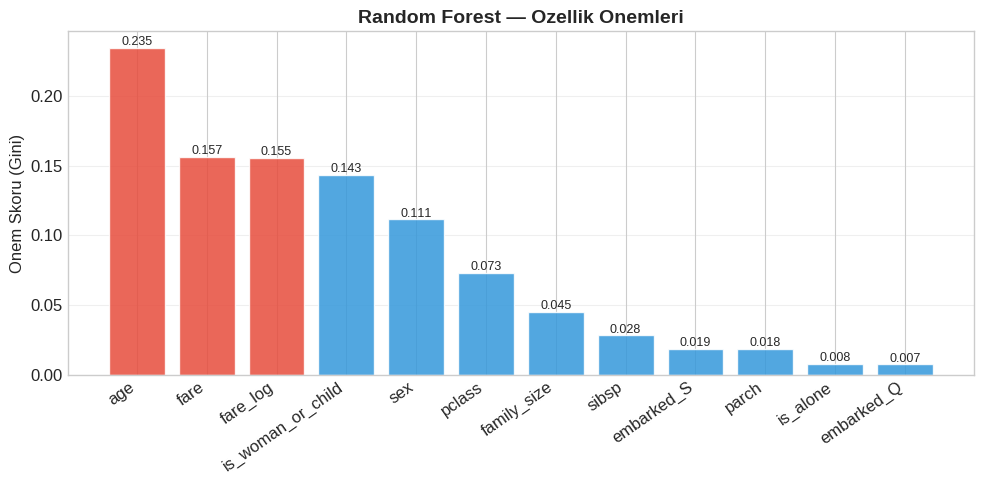

In [28]:
# ── 6E. Tree Feature Importance ─────────────────────────────
# Random Forest modeli, her özelliğin Gini impurity azalmasına
# katkısını ölçer -> çok güçlü bir feature importance yöntemi

rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train_scaled, y_train)

rf_importance = pd.DataFrame({
    'Ozellik'  : X_train.columns,
    'Onem'     : rf_selector.feature_importances_
}).sort_values('Onem', ascending=False)

print("Random Forest Feature Importance:")
display(rf_importance.round(4))

# Görselleştirme
fig, ax = plt.subplots(figsize=(10, 5))
renkler = ['#E74C3C' if i < 3 else '#3498DB' for i in range(len(rf_importance))]
bars = ax.bar(rf_importance['Ozellik'], rf_importance['Onem'],
               color=renkler, alpha=0.85, edgecolor='white')

for bar, val in zip(bars, rf_importance['Onem']):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.002,
            f'{val:.3f}', ha='center', fontsize=9)

ax.set_title("Random Forest — Ozellik Onemleri", fontsize=14, fontweight='bold')
ax.set_ylabel('Onem Skoru (Gini)')
ax.set_xticklabels(rf_importance['Ozellik'], rotation=35, ha='right')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 7. Dengesiz Sınıf Problemi (Imbalanced Data) <a id="7"></a>

**Dengesiz veri**, bir sınıfın diğerine göre çok daha fazla örneğe sahip olduğu durumdur.

### 📊 Neden Sorun?

Örneğin %95 negatif, %5 pozitif varsa:
- Model her şeyi negatif tahmin ederek **%95 accuracy** alır
- Ama asıl ilgilendiğimiz pozitif sınıfı hiç doğru tahmin etmez!
- Fraud, hastalık, arıza tespitinde sık karşılaşılır

### 🔧 Çözümler

| Yöntem | Açıklama |
|---|---|
| **Oversampling** | Az olan sınıftan daha fazla örnek üret |
| **Undersampling** | Çok olan sınıftan örnekleri sil |
| **SMOTE** | Az sınıf için sentetik örnek üret (interpolasyon) |
| **class_weight** | Model kayıp fonksiyonunda az sınıfa ağırlık ver |
| **Threshold Ayarı** | Karar eşiğini optimize et |

Titanic Sinif Dengesi:
survived
0    369
1    258
Name: count, dtype: int64
survived
0    0.589
1    0.411
Name: proportion, dtype: float64

Denge orani: 0.70 (1.0 = tam dengeli)


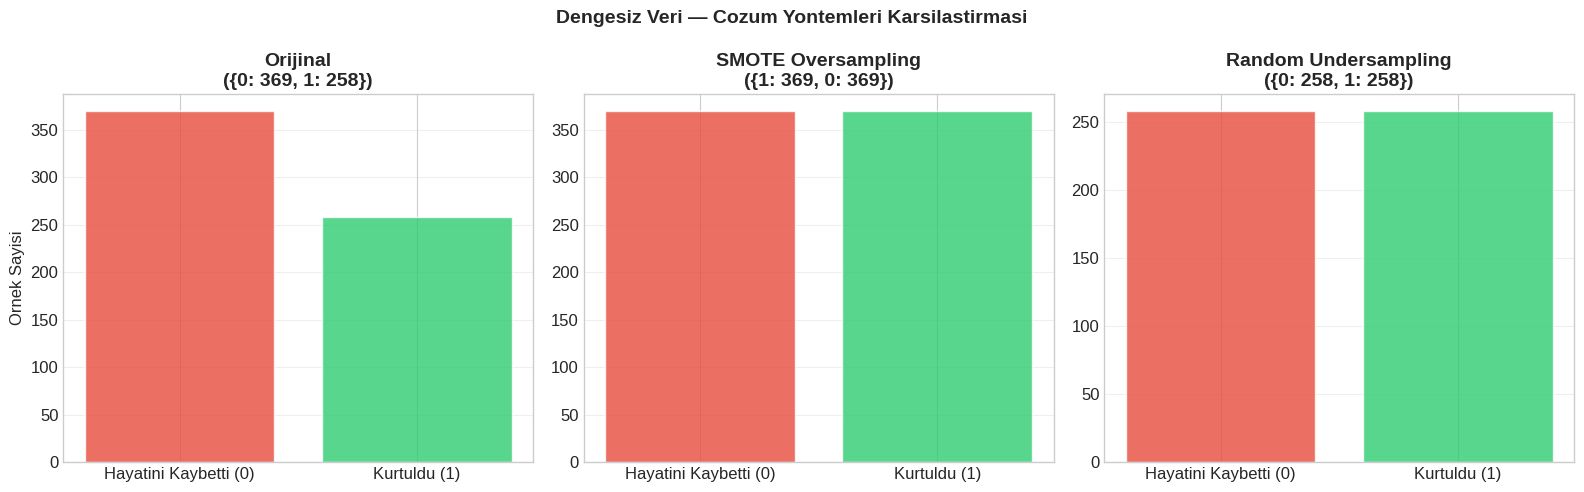


NOT: SMOTE yalnizca egitim verisine uygulanmali!
Test verisi hic dokunulmadan kalmal.


In [29]:
# ══════════════════════════════════════════════════════
# BÖLÜM 7: DENGESIZ SINIF PROBLEMİ
# ══════════════════════════════════════════════════════

# Titanic'teki sınıf dengesini kontrol et
print("Titanic Sinif Dengesi:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True).round(3))

sinif_orani = y_train.value_counts(normalize=True)
print(f"\nDenge orani: {sinif_orani.min()/sinif_orani.max():.2f} (1.0 = tam dengeli)")

# Görselleştirme
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Dengesiz Veri — Cozum Yontemleri Karsilastirmasi", fontsize=14, fontweight='bold')

renkler = ['#E74C3C', '#2ECC71']
etiketler = ['Hayatini Kaybetti (0)', 'Kurtuldu (1)']

# 1. Orijinal
axes[0].bar(etiketler, y_train.value_counts().values, color=renkler, alpha=0.8, edgecolor='white')
axes[0].set_title(f'Orijinal\n({y_train.value_counts().to_dict()})')
axes[0].set_ylabel('Ornek Sayisi')
axes[0].grid(True, alpha=0.3, axis='y')

# 2. SMOTE (sintetik oversampling)
if IMBLEARN_AVAILABLE:
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)
    axes[1].bar(etiketler, pd.Series(y_smote).value_counts().sort_index().values,
                color=renkler, alpha=0.8, edgecolor='white')
    axes[1].set_title(f'SMOTE Oversampling\n({pd.Series(y_smote).value_counts().to_dict()})')
    axes[1].grid(True, alpha=0.3, axis='y')
else:
    axes[1].text(0.5, 0.5, 'imbalanced-learn\nkurulu degil',
                 ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('SMOTE (Kurulu Degil)')

# 3. Random Undersampling
if IMBLEARN_AVAILABLE:
    rus = RandomUnderSampler(random_state=42)
    X_under, y_under = rus.fit_resample(X_train_scaled, y_train)
    axes[2].bar(etiketler, pd.Series(y_under).value_counts().sort_index().values,
                color=renkler, alpha=0.8, edgecolor='white')
    axes[2].set_title(f'Random Undersampling\n({pd.Series(y_under).value_counts().to_dict()})')
    axes[2].grid(True, alpha=0.3, axis='y')
else:
    axes[2].text(0.5, 0.5, 'imbalanced-learn\nkurulu degil',
                 ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Undersampling (Kurulu Degil)')

plt.tight_layout()
plt.show()

print("\nNOT: SMOTE yalnizca egitim verisine uygulanmali!")
print("Test verisi hic dokunulmadan kalmal.")

## 8. Pipeline — Tüm Adımları Birleştirme <a id="8"></a>

**Pipeline**, veri işleme adımlarını ve modeli tek bir nesne altında birleştirir.

### 🏗️ Neden Pipeline?

- **Kod temizliği**: Adımlar sıralı, anlaşılır
- **Data Leakage önlemi**: CV sırasında her fold kendi scaler'ını fit eder
- **Kolay deployment**: Tek nesne -> kaydet/yükle
- **Grid Search uyumu**: Tüm parametreleri birlikte optimize edebilirsin

### 📐 Pipeline Akışı

```
Ham Veri
   │
   ▼
ColumnTransformer
   ├── Sayısal: Impute(median) -> StandardScaler
   └── Kategorik: Impute(mode) -> OneHotEncoder
   │
   ▼
Feature Selection (SelectKBest)
   │
   ▼
Model (LogisticRegression / RandomForest / vb.)
   │
   ▼
Tahmin
```

In [30]:
# ══════════════════════════════════════════════════════
# BÖLÜM 8: PIPELINE
# ══════════════════════════════════════════════════════

# Ham Titanic verisiyle başla (encoding yapılmamış)
df_pipe = df.copy()

# Hedef değişkeni ayır
y_pipe = df_pipe['survived']
X_pipe = df_pipe.drop(columns=['survived'])

# Gereksiz sütunları kaldır
kaldır = ['name', 'ticket', 'cabin']
X_pipe = X_pipe.drop(columns=[c for c in kaldır if c in X_pipe.columns])

# Sayısal ve kategorik sütunları belirle
sayisal_pip = X_pipe.select_dtypes(include=np.number).columns.tolist()
kategorik_pip = X_pipe.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Sayisal sutunlar    : {sayisal_pip}")
print(f"Kategorik sutunlar  : {kategorik_pip}")

# Train/Test ayırımı
X_pip_train, X_pip_test, y_pip_train, y_pip_test = train_test_split(
    X_pipe, y_pipe, test_size=0.2, random_state=42, stratify=y_pipe
)
print(f"\nTrain: {X_pip_train.shape}, Test: {X_pip_test.shape}")

Sayisal sutunlar    : ['pclass', 'age', 'sibsp', 'parch', 'fare']
Kategorik sutunlar  : ['sex', 'embarked']

Train: (627, 8), Test: (157, 8)


In [31]:
# ── Pipeline'ı İnşa Et ──────────────────────────────────────

# 1. Sayısal özellikler için transformer
sayisal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),   # Eksik -> medyan
    ('scaler',  StandardScaler())                     # Ölçekleme
])

# 2. Kategorik özellikler için transformer
kategorik_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Eksik -> mod
    ('onehot',  OneHotEncoder(handle_unknown='ignore',      # Bilinmeyen -> sıfır
                               drop='first',                 # Dummy trap
                               sparse_output=False))
])

# 3. ColumnTransformer: Sayısal ve kategorik'i birleştir
onislemci = ColumnTransformer(
    transformers=[
        ('sayisal',    sayisal_transformer,    sayisal_pip),
        ('kategorik',  kategorik_transformer,  kategorik_pip)
    ],
    remainder='drop'   # Tanımlanmayan sütunları kaldır
)

# 4. Tam Pipeline: Preprocessor + Model
pipeline = Pipeline(steps=[
    ('onislemci', onislemci),
    ('model',     RandomForestClassifier(n_estimators=100, random_state=42))
])

print("Pipeline yapisi:")
print(pipeline)

Pipeline yapisi:
Pipeline(steps=[('onislemci',
                 ColumnTransformer(transformers=[('sayisal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['pclass', 'age', 'sibsp',
                                                   'parch', 'fare']),
                                                 ('kategorik',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHot

In [32]:
# ── Pipeline'ı Eğit ve Değerlendir ──────────────────────────

# Tek satırda tüm süreci çalıştır
pipeline.fit(X_pip_train, y_pip_train)

# Tahmin
y_pred   = pipeline.predict(X_pip_test)
y_prob   = pipeline.predict_proba(X_pip_test)[:, 1]

print("Pipeline Model Sonuclari:")
print(f"  Accuracy : {accuracy_score(y_pip_test, y_pred):.4f}")
print(f"  ROC-AUC  : {roc_auc_score(y_pip_test, y_prob):.4f}")
print(f"  F1-Score : {f1_score(y_pip_test, y_pred):.4f}")
print()
print(classification_report(y_pip_test, y_pred,
                              target_names=['Hayatini Kaybetti', 'Kurtuldu']))

# Pipeline'ı kaydet (production için)
import pickle
with open('titanic_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)
print("Pipeline 'titanic_pipeline.pkl' olarak kaydedildi!")
print("Yukleme: pipeline = pickle.load(open('titanic_pipeline.pkl', 'rb'))")

Pipeline Model Sonuclari:
  Accuracy : 0.8344
  ROC-AUC  : 0.8731
  F1-Score : 0.7937

                   precision    recall  f1-score   support

Hayatini Kaybetti       0.84      0.88      0.86        92
         Kurtuldu       0.82      0.77      0.79        65

         accuracy                           0.83       157
        macro avg       0.83      0.82      0.83       157
     weighted avg       0.83      0.83      0.83       157

Pipeline 'titanic_pipeline.pkl' olarak kaydedildi!
Yukleme: pipeline = pickle.load(open('titanic_pipeline.pkl', 'rb'))


## 9. Model Seçimi ve Karşılaştırma <a id="9"></a>

EDA bulgularımızı kullanarak hangi model ailelerini deneyeceğimize karar verelim.

### 🤔 Model Seçim Rehberi

```
Problem Tipi?
├── Sınıflandırma -> LogReg, RF, XGBoost, SVM, KNN
├── Regresyon -> LinReg, Ridge, Lasso, RF, XGBoost
└── Kümeleme -> KMeans, DBSCAN, Hierarchical

Veri boyutu?
├── Küçük (<1K)   -> Basit modeller, regularization önemli
├── Orta (1K-100K) -> RF, XGBoost, SVM
└── Büyük (>100K) -> LightGBM, SGD, sinir ağları

Yorumlanabilirlik?
├── Yüksek -> LogReg, Decision Tree, Lasso
└── Düşük  -> Ensemble, SVM, Neural Network
```

### ⚡ Bias-Variance Tradeoff

| Model | Bias | Variance | Overfitting Riski |
|---|---|---|---|
| Lineer Regresyon | Yüksek | Düşük | Az |
| Decision Tree (derin) | Düşük | Yüksek | Çok |
| Random Forest | Orta | Orta | Az |
| KNN (k=1) | Düşük | Yüksek | Çok |
| Lasso | Yüksek | Düşük | Az |

In [33]:
# ══════════════════════════════════════════════════════
# BÖLÜM 9: MODEL SEÇİMİ VE KARŞILAŞTIRMA
# ══════════════════════════════════════════════════════

# Tüm modelleri aynı pipeline şablonu üzerinde dene
model_listesi = {
    'Logistic Regression'  : LogisticRegression(max_iter=500, random_state=42),
    'Decision Tree'        : DecisionTreeClassifier(max_depth=5, random_state=42),
    'Random Forest'        : RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting'    : GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM'                  : SVC(probability=True, random_state=42),
    'KNN'                  : KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes'          : GaussianNB(),
}

if XGB_AVAILABLE:
    model_listesi['XGBoost'] = xgb.XGBClassifier(
        n_estimators=100, random_state=42, eval_metric='logloss', verbosity=0
    )
if LGB_AVAILABLE:
    model_listesi['LightGBM'] = lgb.LGBMClassifier(
        n_estimators=100, random_state=42, verbose=-1
    )

print("Model karsilastirma basliyor...")
print(f"{'Model':25s} {'Acc':>8} {'ROC-AUC':>9} {'F1':>8} {'Precision':>10} {'Recall':>8}")
print("-" * 75)

sonuclar = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for isim, model in model_listesi.items():
    # Her model için ayrı pipeline
    pip = Pipeline([
        ('onislemci', onislemci),
        ('model', model)
    ])

    # 5-Fold Cross Validation
    acc_cv    = cross_val_score(pip, X_pipe, y_pipe, cv=cv, scoring='accuracy',  n_jobs=-1)
    auc_cv    = cross_val_score(pip, X_pipe, y_pipe, cv=cv, scoring='roc_auc',   n_jobs=-1)
    f1_cv     = cross_val_score(pip, X_pipe, y_pipe, cv=cv, scoring='f1',        n_jobs=-1)
    prec_cv   = cross_val_score(pip, X_pipe, y_pipe, cv=cv, scoring='precision', n_jobs=-1)
    recall_cv = cross_val_score(pip, X_pipe, y_pipe, cv=cv, scoring='recall',    n_jobs=-1)

    sonuclar[isim] = {
        'Accuracy'  : acc_cv.mean(),
        'ROC_AUC'   : auc_cv.mean(),
        'F1'        : f1_cv.mean(),
        'Precision' : prec_cv.mean(),
        'Recall'    : recall_cv.mean(),
        'Acc_std'   : acc_cv.std(),
        'AUC_std'   : auc_cv.std(),
    }

    print(f"{isim:25s} {acc_cv.mean():>8.4f} {auc_cv.mean():>9.4f} "
          f"{f1_cv.mean():>8.4f} {prec_cv.mean():>10.4f} {recall_cv.mean():>8.4f}")

print("\nTam rapor hazirlanıyor...")

Model karsilastirma basliyor...
Model                          Acc   ROC-AUC       F1  Precision   Recall
---------------------------------------------------------------------------
Logistic Regression         0.7704    0.8388   0.7147     0.7294   0.7026
Decision Tree               0.7806    0.8347   0.7056     0.7917   0.6495
Random Forest               0.7653    0.8204   0.7053     0.7319   0.6839
Gradient Boosting           0.7997    0.8427   0.7368     0.8004   0.6839
SVM                         0.8048    0.8303   0.7439     0.8077   0.6902
KNN                         0.7640    0.8078   0.7022     0.7325   0.6749
Naive Bayes                 0.7589    0.8119   0.6945     0.7207   0.6747
XGBoost                     0.7704    0.8343   0.7173     0.7295   0.7117
LightGBM                    0.7908    0.8430   0.7333     0.7704   0.7025

Tam rapor hazirlanıyor...


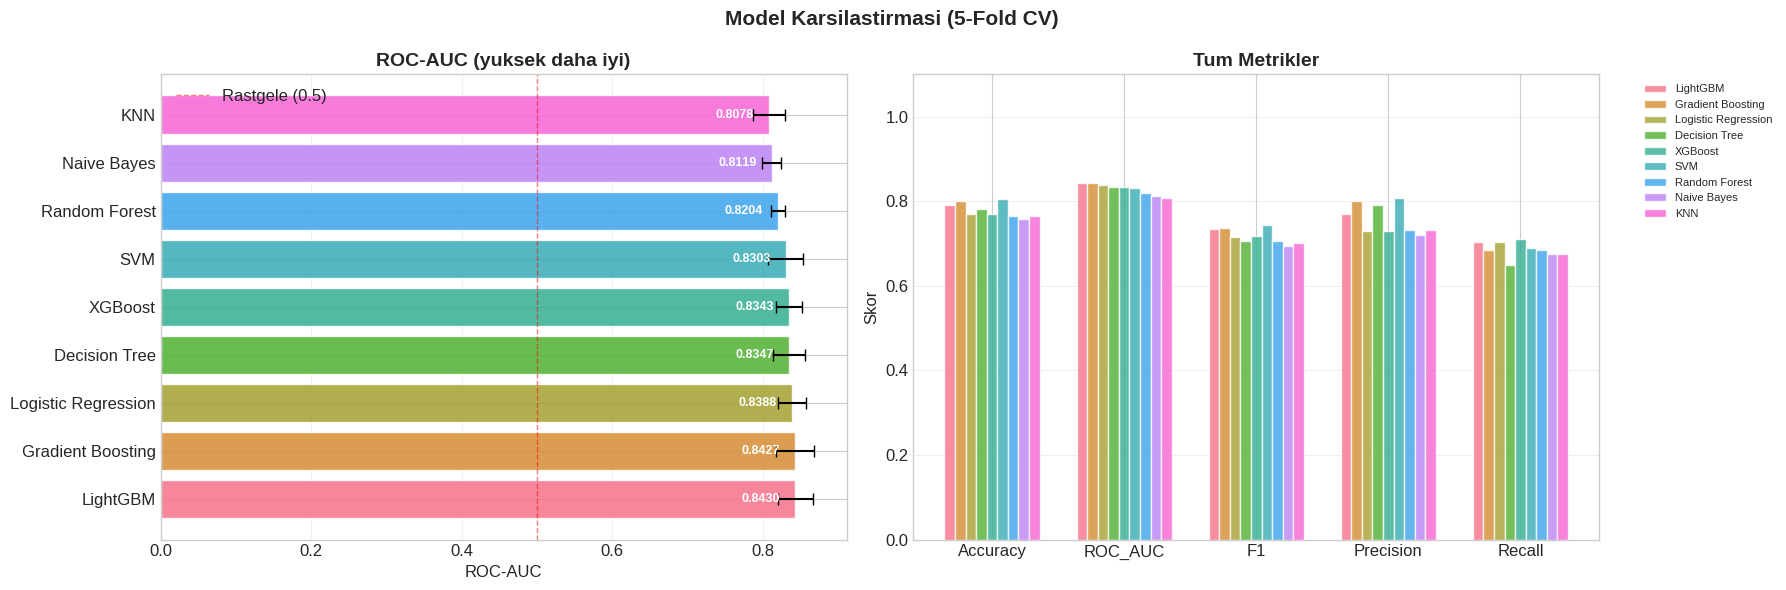


En iyi model (ROC-AUC): LightGBM
En iyi model (F1)     : SVM


In [34]:
# ── Model Karşılaştırma Görselleştirmesi ────────────────────

sonuc_df = pd.DataFrame(sonuclar).T
sonuc_df = sonuc_df.sort_values('ROC_AUC', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("Model Karsilastirmasi (5-Fold CV)", fontsize=15, fontweight='bold')

metrikler = ['Accuracy', 'ROC_AUC', 'F1', 'Precision', 'Recall']
renkler   = sns.color_palette("husl", len(sonuc_df))

# 1. ROC-AUC sıralı bar chart
ax = axes[0]
bars = ax.barh(sonuc_df.index, sonuc_df['ROC_AUC'],
               color=renkler, alpha=0.85, edgecolor='white')
# Hata çubuğu (std)
ax.errorbar(sonuc_df['ROC_AUC'], range(len(sonuc_df)),
            xerr=sonuc_df['AUC_std'], fmt='none',
            color='black', capsize=4, linewidth=1.5)
ax.axvline(0.5, color='red', ls='--', lw=1, alpha=0.5, label='Rastgele (0.5)')
ax.set_title('ROC-AUC (yuksek daha iyi)')
ax.set_xlabel('ROC-AUC')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
for bar, val in zip(bars, sonuc_df['ROC_AUC']):
    ax.text(bar.get_width() - 0.02, bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', ha='right', va='center', fontsize=9,
            color='white', fontweight='bold')

# 2. Radar chart (tüm metrikler)
ax2 = axes[1]
x = np.arange(len(metrikler))
genislik = 0.08

for i, (model_adi, row) in enumerate(sonuc_df.iterrows()):
    vals = [row[m] for m in metrikler]
    ax2.bar(x + i*genislik, vals, width=genislik, label=model_adi,
            color=renkler[i], alpha=0.8, edgecolor='white')

ax2.set_xticks(x + genislik * (len(sonuc_df)-1) / 2)
ax2.set_xticklabels(metrikler)
ax2.set_ylim(0, 1.1)
ax2.set_title('Tum Metrikler')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylabel('Skor')

plt.tight_layout()
plt.show()

print(f"\nEn iyi model (ROC-AUC): {sonuc_df['ROC_AUC'].idxmax()}")
print(f"En iyi model (F1)     : {sonuc_df['F1'].idxmax()}")

## 10. Hiperparametre Optimizasyonu <a id="10"></a>

**Hiperparametreler**, modeli eğitmeden önce dışarıdan belirlenen parametrelerdir.
Örneğin: Random Forest'ta ağaç sayısı, derinlik; KNN'de k değeri.

### 🔎 Arama Yöntemleri

| Yöntem | Nasıl? | Avantaj | Dezavantaj |
|---|---|---|---|
| **Grid Search** | Tüm kombinasyonları dene | Kesin en iyi | Çok yavaş |
| **Random Search** | Rastgele örnekle | Hızlı, genellikle iyi | Garantisiz |
| **Bayesian Opt.** | Önceki sonuçlara göre yönlen | Verimli | Karmaşık |
| **Halving Search** | Eleme turları | Çok hızlı | Yaklaşık |

> 💡 Pratikte **RandomizedSearchCV** çoğu durumda GridSearch kadar iyi sonuç verir,
> çok daha kısa sürede.

In [35]:
# ══════════════════════════════════════════════════════
# BÖLÜM 10: HİPERPARAMETRE OPTİMİZASYONU
# ══════════════════════════════════════════════════════

# ── RandomizedSearchCV: Random Forest ───────────────────────

param_dist = {
    'model__n_estimators'     : [50, 100, 200, 300],
    'model__max_depth'        : [None, 5, 10, 15, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf' : [1, 2, 4],
    'model__max_features'     : ['sqrt', 'log2', 0.5],
    'model__bootstrap'        : [True, False]
}

rf_pipeline = Pipeline([
    ('onislemci', onislemci),
    ('model', RandomForestClassifier(random_state=42, n_jobs=-1))
])

random_search = RandomizedSearchCV(
    estimator  = rf_pipeline,
    param_distributions = param_dist,
    n_iter     = 30,                    # 30 rastgele kombinasyon dene
    cv         = StratifiedKFold(5),
    scoring    = 'roc_auc',
    n_jobs     = -1,
    random_state = 42,
    verbose    = 1
)

print("RandomizedSearchCV basliyor (30 iter × 5-fold = 150 model)...")
random_search.fit(X_pip_train, y_pip_train)

print(f"\nEn iyi parametreler:")
for k, v in random_search.best_params_.items():
    print(f"  {k.replace('model__', ''):30s}: {v}")
print(f"\nEn iyi CV ROC-AUC: {random_search.best_score_:.4f}")

# Test üzerinde değerlendir
y_pred_rs = random_search.predict(X_pip_test)
y_prob_rs = random_search.predict_proba(X_pip_test)[:, 1]
print(f"Test ROC-AUC      : {roc_auc_score(y_pip_test, y_prob_rs):.4f}")
print(f"Test Accuracy     : {accuracy_score(y_pip_test, y_pred_rs):.4f}")

RandomizedSearchCV basliyor (30 iter × 5-fold = 150 model)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

En iyi parametreler:
  n_estimators                  : 200
  min_samples_split             : 2
  min_samples_leaf              : 2
  max_features                  : log2
  max_depth                     : 5
  bootstrap                     : True

En iyi CV ROC-AUC: 0.8350
Test ROC-AUC      : 0.8847
Test Accuracy     : 0.8153


In [36]:
# ── GridSearchCV: Lojistik Regresyon ─────────────────────────
# Küçük parametre uzayı için Grid Search uygundur

param_grid_lr = {
    'model__C'        : [0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization gücü
    'model__penalty'  : ['l1', 'l2', 'elasticnet'],
    'model__solver'   : ['saga'],  # l1, l2, elasticnet hepsini destekler
    'model__l1_ratio' : [0.0, 0.5, 1.0]  # Sadece elasticnet için
}

lr_pipeline = Pipeline([
    ('onislemci', onislemci),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

grid_search = GridSearchCV(
    estimator = lr_pipeline,
    param_grid = param_grid_lr,
    cv         = StratifiedKFold(5),
    scoring    = 'roc_auc',
    n_jobs     = -1,
    verbose    = 0
)

print("GridSearchCV basliyor...")
grid_search.fit(X_pip_train, y_pip_train)

print(f"En iyi parametreler: {grid_search.best_params_}")
print(f"En iyi CV ROC-AUC  : {grid_search.best_score_:.4f}")

# CV sonuçlarını görselleştir
cv_sonuc = pd.DataFrame(grid_search.cv_results_)
cv_sonuc = cv_sonuc.sort_values('mean_test_score', ascending=False).head(10)

print("\nTop 10 kombinasyon:")
display(cv_sonuc[['params', 'mean_test_score', 'std_test_score']].round(4))

GridSearchCV basliyor...
En iyi parametreler: {'model__C': 10.0, 'model__l1_ratio': 0.5, 'model__penalty': 'elasticnet', 'model__solver': 'saga'}
En iyi CV ROC-AUC  : 0.8295

Top 10 kombinasyon:


,params,mean_test_score,std_test_score
32,"{'model__C': 10.0, 'model__l1_ratio': 0.5, 'mo...",0.8295,0.0532
42,"{'model__C': 100.0, 'model__l1_ratio': 1.0, 'm...",0.8294,0.0532
36,"{'model__C': 100.0, 'model__l1_ratio': 0.0, 'm...",0.8294,0.0532
39,"{'model__C': 100.0, 'model__l1_ratio': 0.5, 'm...",0.8294,0.0532
44,"{'model__C': 100.0, 'model__l1_ratio': 1.0, 'm...",0.8294,0.0532
38,"{'model__C': 100.0, 'model__l1_ratio': 0.0, 'm...",0.8294,0.0533
37,"{'model__C': 100.0, 'model__l1_ratio': 0.0, 'm...",0.8294,0.0533
40,"{'model__C': 100.0, 'model__l1_ratio': 0.5, 'm...",0.8294,0.0533
43,"{'model__C': 100.0, 'model__l1_ratio': 1.0, 'm...",0.8294,0.0533
41,"{'model__C': 100.0, 'model__l1_ratio': 0.5, 'm...",0.8294,0.0533


## 11. Model Değerlendirme Metrikleri <a id="11"></a>

### 📊 Sınıflandırma Metrikleri

**Confusion Matrix:**
```
                  Tahmin: 0       Tahmin: 1
Gerçek: 0    [ TN (True Neg) | FP (False Pos) ]
Gerçek: 1    [ FN (False Neg) | TP (True Pos)  ]
```

| Metrik | Formül | Ne Söyler? | Ne Zaman? |
|---|---|---|---|
| **Accuracy** | (TP+TN) / N | Genel doğruluk | Dengeli sınıf |
| **Precision** | TP / (TP+FP) | Pozitif tahmin güvenilirliği | FP maliyetli |
| **Recall** | TP / (TP+FN) | Gerçek pozitifleri yakalama | FN maliyetli |
| **F1** | 2×P×R / (P+R) | Precision-Recall dengesi | Dengesiz sınıf |
| **ROC-AUC** | Eğri altı alan | Eşik bağımsız performans | Genel güç |
| **PR-AUC** | P-R eğrisi alanı | Dengesiz sınıf özelinde | Çok dengesiz |

### 🎯 Regresyon Metrikleri

| Metrik | Formül | Yorum |
|---|---|---|
| **MAE** | Σ|y-ŷ| / n | Ortalama mutlak hata, yorumlanabilir |
| **MSE** | Σ(y-ŷ)² / n | Büyük hatalara duyarlı |
| **RMSE** | √MSE | MSE'nin birim ölçeğinde versiyonu |
| **R²** | 1 - SS_res/SS_tot | Açıklanan varyans oranı [0,1] |
| **MAPE** | Σ|y-ŷ|/y / n | Yüzde hata |

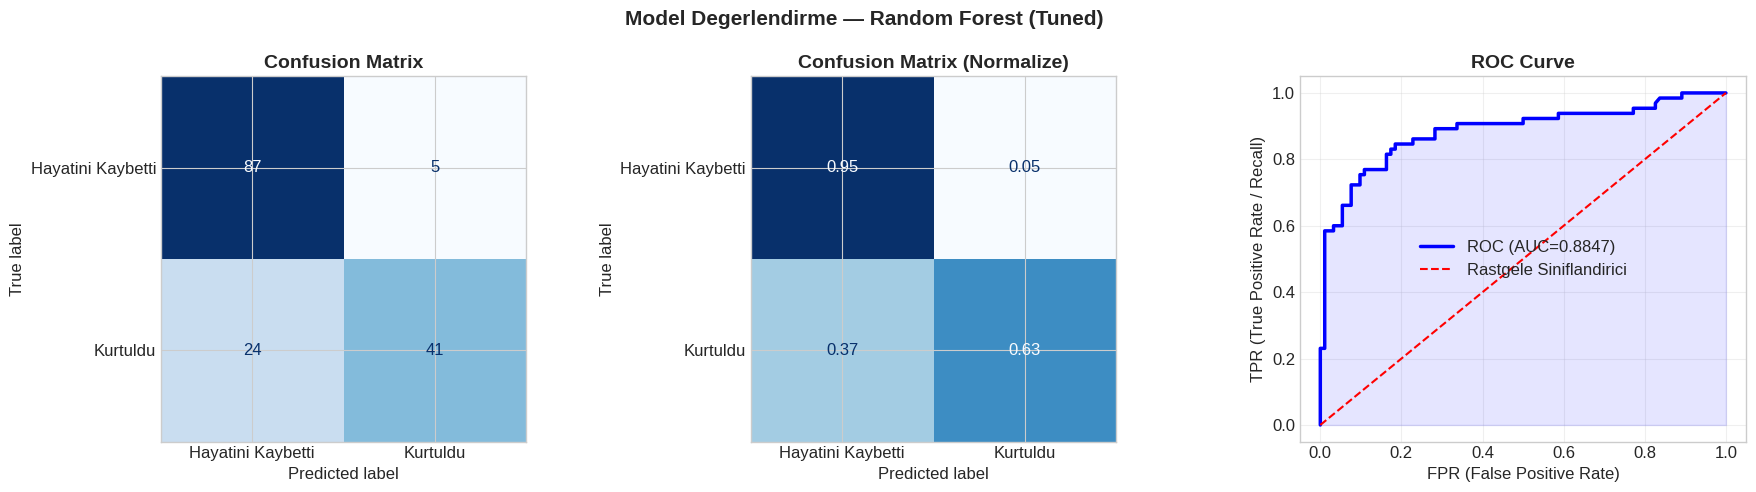


Final Model Metrikleri:
  Accuracy   : 0.8153
  Precision  : 0.8913
  Recall     : 0.6308
  F1-Score   : 0.7387
  ROC-AUC    : 0.8847

                   precision    recall  f1-score   support

Hayatini Kaybetti       0.78      0.95      0.86        92
         Kurtuldu       0.89      0.63      0.74        65

         accuracy                           0.82       157
        macro avg       0.84      0.79      0.80       157
     weighted avg       0.83      0.82      0.81       157



In [37]:
# ══════════════════════════════════════════════════════
# BÖLÜM 11: MODEL DEĞERLENDİRME
# ══════════════════════════════════════════════════════

# En iyi pipeline'ı kullan
en_iyi_model = random_search.best_estimator_

y_pred_final = en_iyi_model.predict(X_pip_test)
y_prob_final = en_iyi_model.predict_proba(X_pip_test)[:, 1]

# ── 11A. Confusion Matrix ────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Model Degerlendirme — Random Forest (Tuned)", fontsize=15, fontweight='bold')

# 1. Confusion Matrix (sayı)
cm = confusion_matrix(y_pip_test, y_pred_final)
disp = ConfusionMatrixDisplay(cm, display_labels=['Hayatini Kaybetti', 'Kurtuldu'])
disp.plot(ax=axes[0], colorbar=False, cmap='Blues')
axes[0].set_title('Confusion Matrix')

# 2. Confusion Matrix (yüzde)
cm_norm = confusion_matrix(y_pip_test, y_pred_final, normalize='true')
disp2   = ConfusionMatrixDisplay(cm_norm.round(2), display_labels=['Hayatini Kaybetti', 'Kurtuldu'])
disp2.plot(ax=axes[1], colorbar=False, cmap='Blues')
axes[1].set_title('Confusion Matrix (Normalize)')

# 3. ROC Curve
fpr, tpr, esikler = roc_curve(y_pip_test, y_prob_final)
auc_skoru = roc_auc_score(y_pip_test, y_prob_final)

axes[2].plot(fpr, tpr, 'b-', linewidth=2.5, label=f'ROC (AUC={auc_skoru:.4f})')
axes[2].plot([0, 1], [0, 1], 'r--', lw=1.5, label='Rastgele Siniflandirici')
axes[2].fill_between(fpr, tpr, alpha=0.1, color='blue')
axes[2].set_xlabel('FPR (False Positive Rate)')
axes[2].set_ylabel('TPR (True Positive Rate / Recall)')
axes[2].set_title('ROC Curve')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Metrikleri yazdır
print("\nFinal Model Metrikleri:")
print(f"  Accuracy   : {accuracy_score(y_pip_test, y_pred_final):.4f}")
print(f"  Precision  : {precision_score(y_pip_test, y_pred_final):.4f}")
print(f"  Recall     : {recall_score(y_pip_test, y_pred_final):.4f}")
print(f"  F1-Score   : {f1_score(y_pip_test, y_pred_final):.4f}")
print(f"  ROC-AUC    : {auc_skoru:.4f}")
print()
print(classification_report(y_pip_test, y_pred_final,
                              target_names=['Hayatini Kaybetti', 'Kurtuldu']))

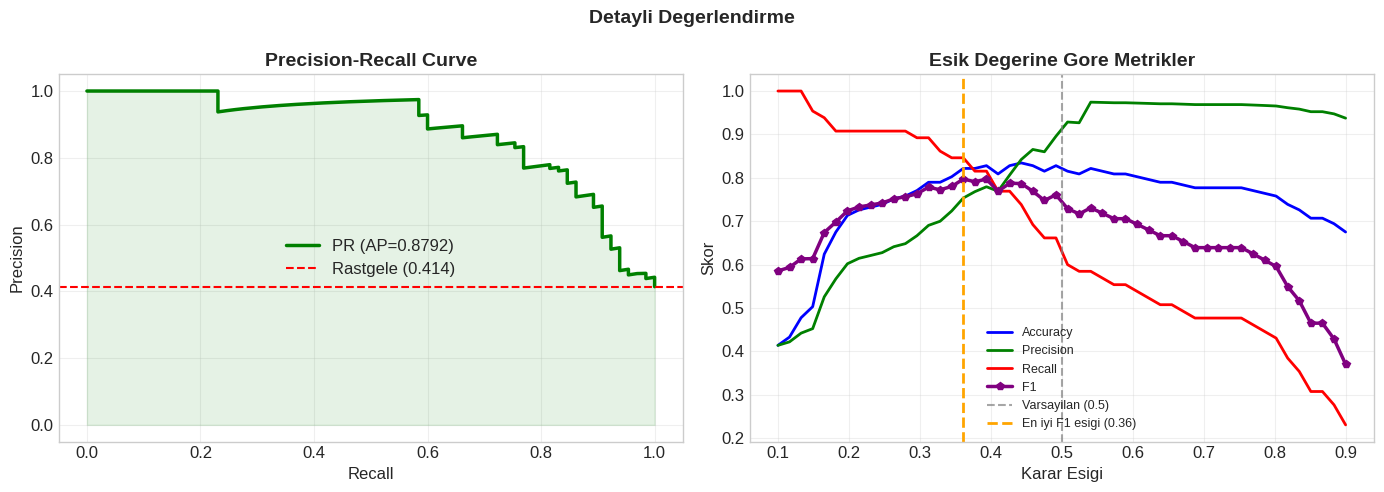

En iyi F1 esigi: 0.36
Bu esikle F1   : 0.7971


In [38]:
# ── 11B. Precision-Recall Curve ─────────────────────────────
# Dengesiz veri setlerinde ROC-AUC yanıltıcı olabilir
# PR eğrisi daha bilgilendirici

from sklearn.metrics import precision_recall_curve, average_precision_score

precision_arr, recall_arr, esikler_pr = precision_recall_curve(y_pip_test, y_prob_final)
ap_skoru = average_precision_score(y_pip_test, y_prob_final)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Detayli Degerlendirme", fontsize=14, fontweight='bold')

# 1. PR Curve
axes[0].plot(recall_arr, precision_arr, 'g-', linewidth=2.5,
             label=f'PR (AP={ap_skoru:.4f})')
axes[0].axhline(y_pip_test.mean(), color='red', ls='--',
                label=f'Rastgele ({y_pip_test.mean():.3f})')
axes[0].fill_between(recall_arr, precision_arr, alpha=0.1, color='green')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Precision-Recall Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Threshold vs Metric
esikler_range = np.linspace(0.1, 0.9, 50)
acc_list, prec_list, rec_list, f1_list = [], [], [], []

for esik in esikler_range:
    y_pred_esik = (y_prob_final >= esik).astype(int)
    acc_list.append(accuracy_score(y_pip_test, y_pred_esik))
    prec_list.append(precision_score(y_pip_test, y_pred_esik, zero_division=0))
    rec_list.append(recall_score(y_pip_test, y_pred_esik, zero_division=0))
    f1_list.append(f1_score(y_pip_test, y_pred_esik, zero_division=0))

axes[1].plot(esikler_range, acc_list,  'b-', linewidth=2, label='Accuracy')
axes[1].plot(esikler_range, prec_list, 'g-', linewidth=2, label='Precision')
axes[1].plot(esikler_range, rec_list,  'r-', linewidth=2, label='Recall')
axes[1].plot(esikler_range, f1_list,   'p-', linewidth=2.5, label='F1', color='purple')
axes[1].axvline(0.5, color='gray', ls='--', alpha=0.7, label='Varsayilan (0.5)')

# En iyi F1 noktasını işaretle
en_iyi_esik = esikler_range[np.argmax(f1_list)]
axes[1].axvline(en_iyi_esik, color='orange', ls='--', lw=2,
                label=f'En iyi F1 esigi ({en_iyi_esik:.2f})')
axes[1].set_xlabel('Karar Esigi')
axes[1].set_ylabel('Skor')
axes[1].set_title('Esik Degerine Gore Metrikler')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"En iyi F1 esigi: {en_iyi_esik:.2f}")
print(f"Bu esikle F1   : {max(f1_list):.4f}")

## 12. Model Yorumlama (SHAP) <a id="12"></a>

**SHAP (SHapley Additive exPlanations)**, her özelliğin modelin tahminlerine katkısını
oyun teorisinden esinlenerek hesaplar.

### 🎯 SHAP Ne Sağlar?

- **Global açıklama**: Hangi özellik genel olarak en önemli?
- **Lokal açıklama**: Bu spesifik tahmin neden böyle çıktı?
- **Etkileşim analizi**: İki özellik birlikte nasıl etki ediyor?

### 📊 SHAP Grafikleri

| Grafik | Açıklama |
|---|---|
| **Summary Plot** | Özellik önem + etki yönü |
| **Waterfall** | Tek tahmin için katkılar |
| **Dependence Plot** | Özellik değeri vs SHAP değeri |
| **Force Plot** | İnteraktif tek tahmin açıklaması |

SHAP analizi basliyor...
1/2: SHAP Beeswarm Summary Plot


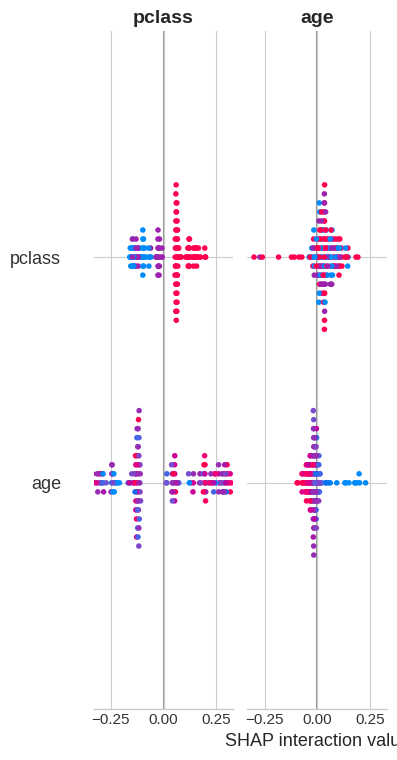

2/2: SHAP Feature Importance (Bar)


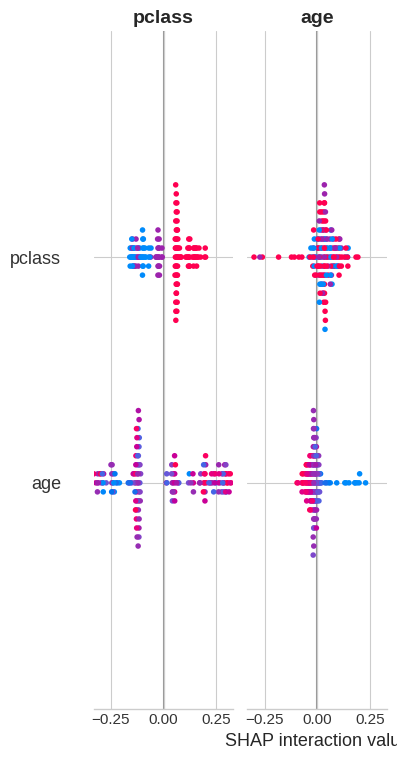

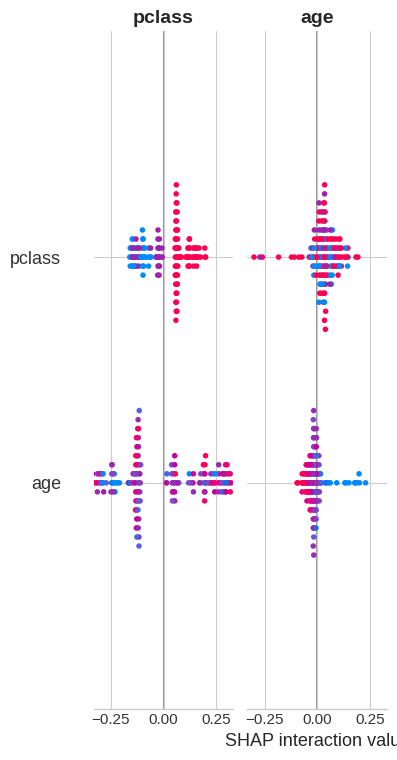

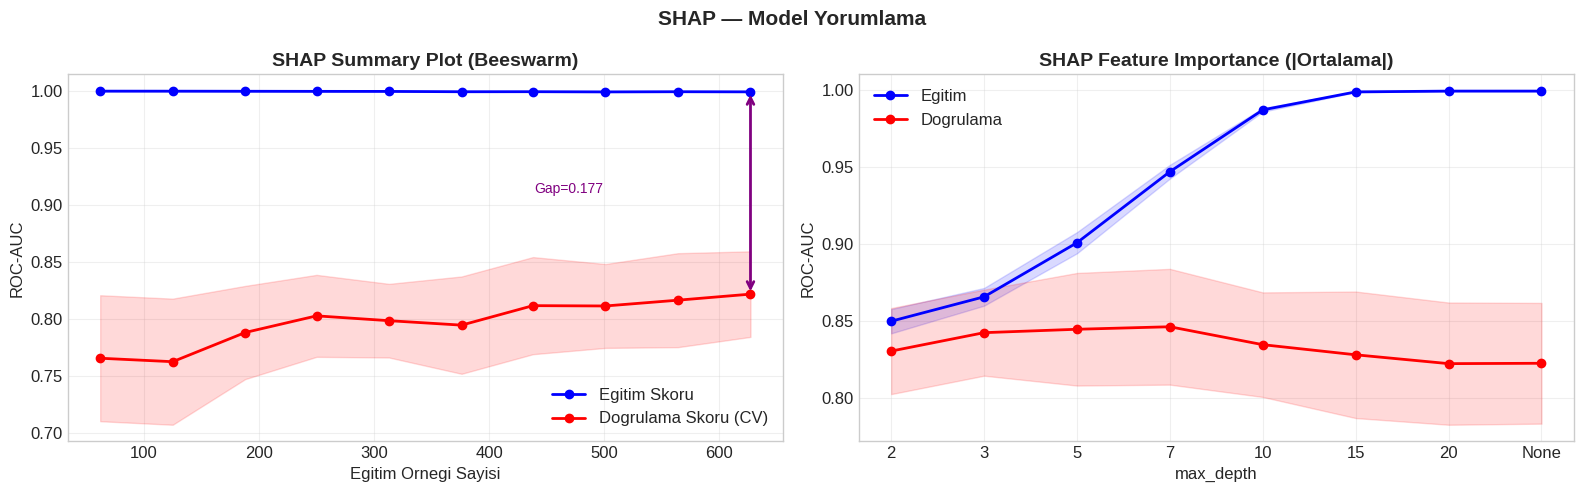

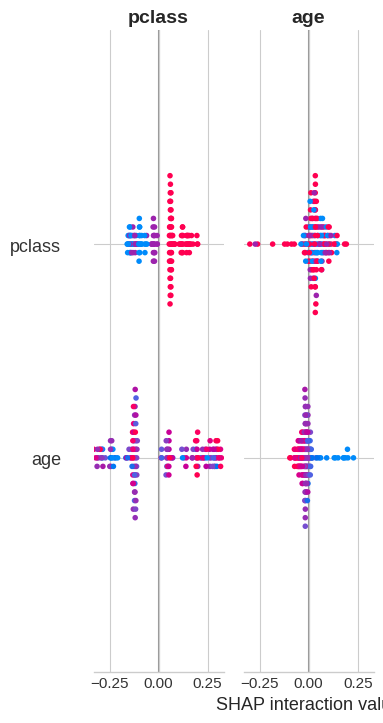


Ornek: 0. gozlem icin SHAP waterfall plot


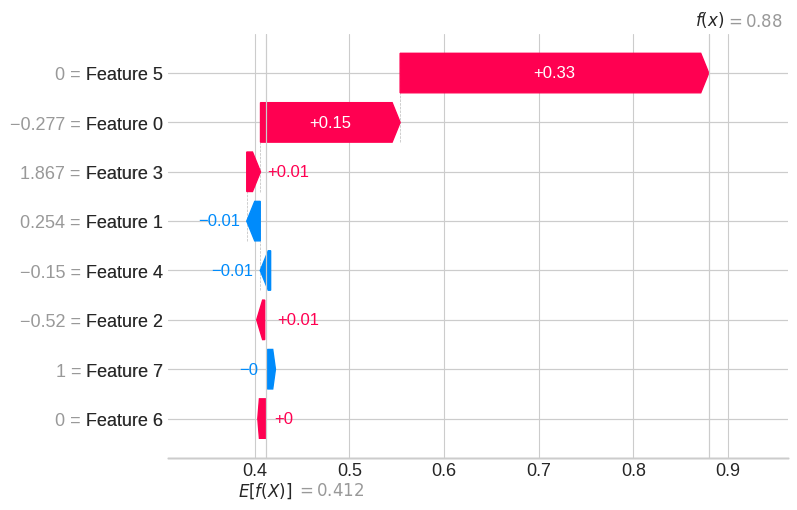

In [52]:
# ══════════════════════════════════════════════════════
# BÖLÜM 12: SHAP MODEL YORUMLAMA
# ══════════════════════════════════════════════════════

if SHAP_AVAILABLE:
    print("SHAP analizi basliyor...")

    # Pipeline'dan preprocessor ve modeli ayır
    X_pip_test_transformed = en_iyi_model.named_steps['onislemci'].transform(X_pip_test)
    rf_final = en_iyi_model.named_steps['model']

    # Özellik adlarını al
    try:
        cat_enc = en_iyi_model.named_steps['onislemci'].named_transformers_['kategorik']
        ohe_ozellikler = cat_enc.named_steps['onehot'].get_feature_names_out(kategorik_pip).tolist()
    except:
        ohe_ozellikler = []

    tum_ozellikler = sayisal_pip + ohe_ozellikler

    # SHAP değerlerini hesapla
    # TreeExplainer ağaç tabanlı modeller için optimize edilmiştir
    explainer   = shap.TreeExplainer(rf_final)
    shap_values = explainer.shap_values(X_pip_test_transformed)

    # İkili sınıflandırmada shap_values liste olarak gelir: [sinif0, sinif1]
    # Pozitif sınıf (1 = Kurtuldu) için indeks 1'i alıyoruz
    shap_pos = shap_values[1] if isinstance(shap_values, list) else shap_values

    # fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle("SHAP — Model Yorumlama", fontsize=15, fontweight='bold')


    # YENİ (dogru — her plot ayri cagrilir)
    print("1/2: SHAP Beeswarm Summary Plot")
    shap.summary_plot(
        shap_pos,
        X_pip_test_transformed,
        feature_names=tum_ozellikler[:shap_pos.shape[1]],
        max_display=12,
        plot_size=(12, 6),
        show=True   # kendi figure'ini kendisi goster
    )

    print("2/2: SHAP Feature Importance (Bar)")
    shap.summary_plot(
        shap_pos,
        X_pip_test_transformed,
        feature_names=tum_ozellikler[:shap_pos.shape[1]],
        plot_type='bar',
        max_display=12,
        plot_size=(12, 6),
        show=True
    )


    # 1. Summary Plot (Beeswarm) — her özelliğin tüm gözlemler için SHAP dağılımı
    plt.sca(axes[0])
    shap.summary_plot(
        shap_pos,
        X_pip_test_transformed,
        feature_names=tum_ozellikler[:shap_pos.shape[1]],
        max_display=12,
        show=False
    )
    axes[0].set_title("SHAP Summary Plot (Beeswarm)")

    # 2. Feature Importance (bar) — ortalama |SHAP| değeri
    plt.sca(axes[1])
    shap.summary_plot(
        shap_pos,
        X_pip_test_transformed,
        feature_names=tum_ozellikler[:shap_pos.shape[1]],
        plot_type='bar',
        max_display=12,
        show=False
    )
    axes[1].set_title("SHAP Feature Importance (|Ortalama|)")

    plt.tight_layout()
    plt.show()

    # ── Tek gözlem için Waterfall Plot (lokal açıklama) ──────
    # [0, 1] → 0. gözlem, sınıf 1 (pozitif/Kurtuldu)
    # explainer() doğrudan Explanation nesnesi döndürür — manuel oluşturmaya gerek yok
    print("\nOrnek: 0. gozlem icin SHAP waterfall plot")
    shap_explanation = explainer(X_pip_test_transformed)
    shap.plots.waterfall(
        shap_explanation[:, :, 1][0],   # tüm gözlemler → sınıf 1 → 0. gözlem
        max_display=10
    )

else:
    print("SHAP kurulu degil: pip install shap")
    print("Kurulumdan sonra bu bolumu tekrar calistirin.")
    print()

    # Alternatif: Permutation Importance
    from sklearn.inspection import permutation_importance
    result = permutation_importance(
        en_iyi_model, X_pip_test, y_pip_test,
        n_repeats=10, random_state=42, n_jobs=-1, scoring='roc_auc'
    )
    perm_df = pd.DataFrame({
        'Ozellik' : X_pipe.columns,
        'Onem'    : result.importances_mean,
        'Std'     : result.importances_std
    }).sort_values('Onem', ascending=False)

    print("Permutation Importance (SHAP alternatifi):")
    display(perm_df.round(4))

## 13. Cross-Validation Stratejileri <a id="13"></a>

**Cross-Validation (CV)**, modelin genelleme performansını güvenilir biçimde ölçer.

### 🔄 CV Türleri

| Tür | Açıklama | Ne Zaman? |
|---|---|---|
| **K-Fold** | Veriyi K parçaya böl, her biri bir kere test | Genel kullanım |
| **Stratified K-Fold** | Sınıf oranını koruyarak K parça | Dengesiz sınıf |
| **Leave-One-Out** | Her gözlem bir kez test | Çok küçük veri |
| **Time Series Split** | Kronolojik bölme | Zaman serisi |
| **Group K-Fold** | Grup bilgisi varken | Hasta/müşteri grupları |

### 📊 Learning Curve

Learning curve, modelin ne kadar veriye ihtiyaç duyduğunu gösterir:
- **Yüksek bias**: Hem train hem test skoru düşük -> daha karmaşık model
- **Yüksek variance**: Train yüksek, test düşük -> daha fazla veri veya regularization

In [49]:
# ══════════════════════════════════════════════════════
# BÖLÜM 13: CROSS-VALIDATION
# ══════════════════════════════════════════════════════

# ── 13A. Farklı CV Stratejilerini Karşılaştır ────────────────
from sklearn.model_selection import KFold, LeaveOneOut, RepeatedStratifiedKFold

cv_stratejileri = {
    'KFold (5)'              : KFold(n_splits=5, shuffle=True, random_state=42),
    'Stratified KFold (5)'   : StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    'Stratified KFold (10)'  : StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    'Repeated SKFold (5x3)'  : RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42),
}

test_modeli = Pipeline([
    ('onislemci', onislemci),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

print(f"{'CV Stratejisi':30s} {'Ort AUC':>10} {'Std':>8} {'Min':>8} {'Max':>8}")
print("-" * 65)

for isim, cv_str in cv_stratejileri.items():
    skorlar = cross_val_score(test_modeli, X_pipe, y_pipe,
                               cv=cv_str, scoring='roc_auc', n_jobs=-1)
    print(f"{isim:30s} {skorlar.mean():>10.4f} {skorlar.std():>8.4f} "
          f"{skorlar.min():>8.4f} {skorlar.max():>8.4f}")

CV Stratejisi                     Ort AUC      Std      Min      Max
-----------------------------------------------------------------
KFold (5)                          0.8337   0.0313   0.8059   0.8803
Stratified KFold (5)               0.8204   0.0093   0.8091   0.8367
Stratified KFold (10)              0.8341   0.0313   0.7870   0.8841
Repeated SKFold (5x3)              0.8263   0.0260   0.7697   0.8608


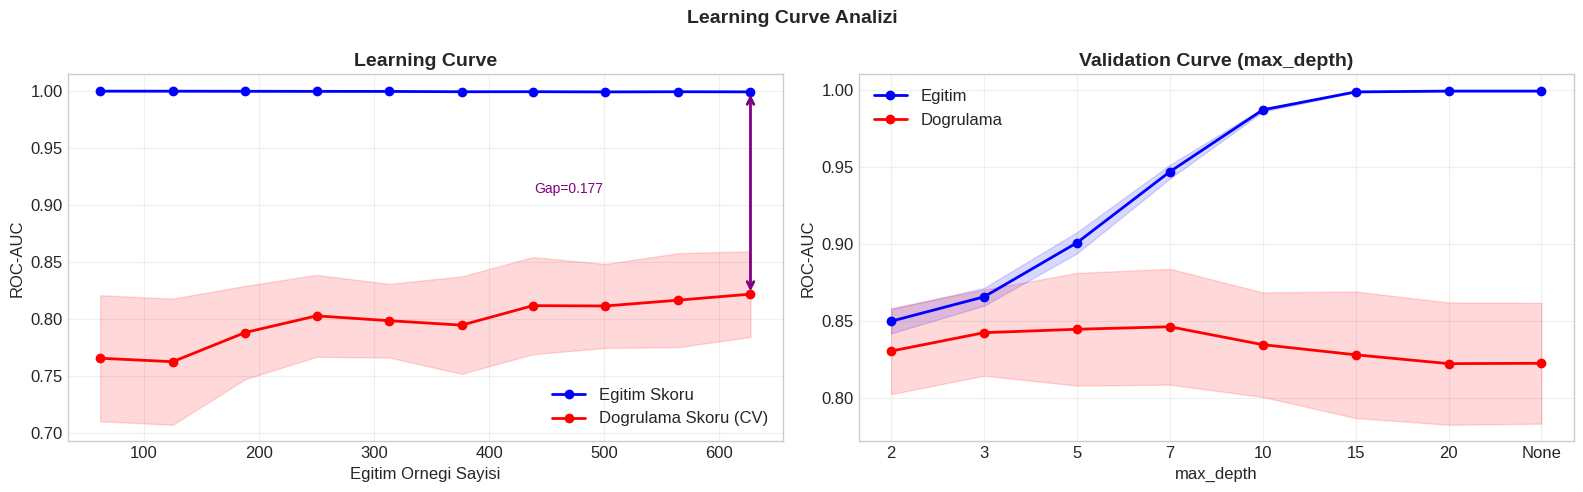


Learning Curve Yorum:
  Train-Val farki (son nokta): 0.1774
  Yuksek fark -> Overfitting! Regularization veya daha az karmasik model deneyin.


In [50]:
# ── 13B. Learning Curve ─────────────────────────────────────
# Modelin eğitim boyutuna göre nasıl geliştiğini gösterir
# Overfitting / underfitting teşhisi için kritik

from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    estimator  = test_modeli,
    X          = X_pipe,
    y          = y_pipe,
    cv         = StratifiedKFold(5),
    train_sizes= np.linspace(0.1, 1.0, 10),
    scoring    = 'roc_auc',
    n_jobs     = -1
)

# Ortalama ve std hesapla
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Learning Curve Analizi", fontsize=14, fontweight='bold')

# Learning Curve
ax = axes[0]
ax.plot(train_sizes, train_mean, 'b-o', linewidth=2, markersize=6, label='Egitim Skoru')
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                alpha=0.15, color='blue')
ax.plot(train_sizes, val_mean, 'r-o', linewidth=2, markersize=6, label='Dogrulama Skoru (CV)')
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                alpha=0.15, color='red')
ax.set_xlabel('Egitim Ornegi Sayisi')
ax.set_ylabel('ROC-AUC')
ax.set_title('Learning Curve')
ax.legend()
ax.grid(True, alpha=0.3)

# Yorum
ax.annotate('', xy=(train_sizes[-1], val_mean[-1]),
            xytext=(train_sizes[-1], train_mean[-1]),
            arrowprops=dict(arrowstyle='<->', color='purple', lw=2))
fark = train_mean[-1] - val_mean[-1]
ax.text(train_sizes[-1]*0.7, (train_mean[-1]+val_mean[-1])/2,
        f'Gap={fark:.3f}', color='purple', fontsize=10)

# Validation Curve (max_depth hiperparametresi)
from sklearn.model_selection import validation_curve

param_araligi = [2, 3, 5, 7, 10, 15, 20, None]

train_v, val_v = validation_curve(
    Pipeline([
        ('onislemci', onislemci),
        ('model', RandomForestClassifier(n_estimators=50, random_state=42))
    ]),
    X_pipe, y_pipe,
    param_name='model__max_depth',
    param_range=param_araligi,
    cv=StratifiedKFold(5),
    scoring='roc_auc',
    n_jobs=-1
)

x_labels = [str(d) if d is not None else 'None' for d in param_araligi]
axes[1].plot(x_labels, train_v.mean(axis=1), 'b-o', lw=2, label='Egitim')
axes[1].fill_between(range(len(x_labels)),
                     train_v.mean(axis=1) - train_v.std(axis=1),
                     train_v.mean(axis=1) + train_v.std(axis=1),
                     alpha=0.15, color='blue')
axes[1].plot(x_labels, val_v.mean(axis=1), 'r-o', lw=2, label='Dogrulama')
axes[1].fill_between(range(len(x_labels)),
                     val_v.mean(axis=1) - val_v.std(axis=1),
                     val_v.mean(axis=1) + val_v.std(axis=1),
                     alpha=0.15, color='red')
axes[1].set_xlabel('max_depth')
axes[1].set_ylabel('ROC-AUC')
axes[1].set_title('Validation Curve (max_depth)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLearning Curve Yorum:")
print(f"  Train-Val farki (son nokta): {fark:.4f}")
if fark > 0.1:
    print("  Yuksek fark -> Overfitting! Regularization veya daha az karmasik model deneyin.")
elif val_mean[-1] < 0.7:
    print("  Dusuk dogrulama skoru -> Underfitting! Daha karmasik model veya daha fazla feature deneyin.")
else:
    print("  Iyi denge! Model makul sekilde genelliyor.")

## 14. Sonuç ve Production Hazırlığı <a id="14"></a>

### 🏭 Production'a Taşıma Kontrol Listesi

Bu notebook'taki adımları tamamladıktan sonra modeli production'a taşımadan önce:

#### ✅ Veri Kalitesi
- [ ] Tüm eksik değerler işlendi
- [ ] Aykırı değerler için strateji belirlendi
- [ ] Veri tipleri doğrulandı
- [ ] Data leakage kontrol edildi

#### ✅ Feature Engineering
- [ ] Yeni özellikler domain knowledge ile türetildi
- [ ] Encoding yöntemleri seçildi (OHE / Label / Target)
- [ ] Scaling yöntemi seçildi (model tipine uygun)

#### ✅ Model
- [ ] Birden fazla model karşılaştırıldı
- [ ] Hiperparametre optimizasyonu yapıldı
- [ ] CV ile güvenilir performans ölçüldü
- [ ] Learning curve analizi yapıldı (overfitting kontrolü)

#### ✅ Değerlendirme
- [ ] Problem tipine uygun metrik seçildi
- [ ] Confusion matrix incelendi
- [ ] ROC-AUC ve PR-AUC hesaplandı
- [ ] Karar eşiği optimize edildi

#### ✅ Yorumlanabilirlik
- [ ] Feature importance analizi yapıldı
- [ ] SHAP değerleri hesaplandı
- [ ] Model kararları açıklanabilir

#### ✅ Production
- [ ] Pipeline pickle ile kaydedildi
- [ ] Yeniden eğitim stratejisi belirlendi
- [ ] Model monitoring planı oluşturuldu

---


*📚 Bu notebook, Uygulamalı Makine Öğrenmesi dersinin 2. bölümüdür.*  
*🎓 Keyifli Çalışmalar!*

In [51]:
# ══════════════════════════════════════════════════════
# BÖLÜM 14: ÖZET VE MODEL KAYDETME
# ══════════════════════════════════════════════════════

print("=" * 60)
print("  NOTEBOOK OZETI")
print("=" * 60)

print("Veri Temizleme   : Eksik doldurma, winsorize, gereksiz sutunlar kaldirildi")
print("Feature Eng.     : family_size, is_alone, age_group, fare_log, title, is_woman_or_child")
print("Encoding         : OneHot (embarked), Binary (sex)")
print("Scaling          : StandardScaler (sadece train e fit)")
print("Feature Select   : RFECV + RF Importance")
en_iyi = sonuc_df["ROC_AUC"].idxmax()
en_iyi_auc = sonuc_df["ROC_AUC"].max()
best_cv = random_search.best_score_
print(f"En iyi model     : {en_iyi} (AUC={en_iyi_auc:.4f})")
print(f"HyperOpt AUC     : {best_cv:.4f} (RandomizedSearchCV)")
print("Degerlendirme    : Confusion Matrix, ROC, PR Curve, Esik opt.")

# Pipeline'ı kaydet
import pickle, os

with open('titanic_production_pipeline.pkl', 'wb') as f:
    pickle.dump(random_search.best_estimator_, f)

print("Production pipeline kaydedildi: titanic_production_pipeline.pkl")
print()
print("Kullanim ornegi:")
print("  import pickle")
print("  model = pickle.load(open('titanic_production_pipeline.pkl', 'rb'))")
print("  tahmin = model.predict(yeni_veri)")
print("  olasilik = model.predict_proba(yeni_veri)[:, 1]")

  NOTEBOOK OZETI
Veri Temizleme   : Eksik doldurma, winsorize, gereksiz sutunlar kaldirildi
Feature Eng.     : family_size, is_alone, age_group, fare_log, title, is_woman_or_child
Encoding         : OneHot (embarked), Binary (sex)
Scaling          : StandardScaler (sadece train e fit)
Feature Select   : RFECV + RF Importance
En iyi model     : LightGBM (AUC=0.8430)
HyperOpt AUC     : 0.8350 (RandomizedSearchCV)
Degerlendirme    : Confusion Matrix, ROC, PR Curve, Esik opt.
Production pipeline kaydedildi: titanic_production_pipeline.pkl

Kullanim ornegi:
  import pickle
  model = pickle.load(open('titanic_production_pipeline.pkl', 'rb'))
  tahmin = model.predict(yeni_veri)
  olasilik = model.predict_proba(yeni_veri)[:, 1]
